In [1]:
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import napari
import pickle

In [2]:
from skimage import data
from scipy import stats
from scipy import signal
from tifffile import tifffile
from os.path import sep
from matplotlib import pyplot as plt
import math
import matplotlib.colors as colors
import xarray as xr
import pandas as pd
import seaborn as sns
import json
import os

In [3]:
from fly2p_function_TQ.imaging_2p_preprocessing import combine_single_tiff, computeMotionShift, motionCorrection, low_pass_filter_TQ, high_pass_filter_TQ, averaging_frame
from fly2p_function_TQ.imaging_2p_PVA_functions import PVA_radian_calcul, PVAangleToRoi, PVA_radian_to_angle, PVA_angle_to_radian, calcualteBumpAmplitude
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import downsample_heading_to_total_volume, offset_calculation,fictrack_signal_decoding,moving_wrapped_plot_by_offset

In [356]:
#Just used for reading single tiff file
#image = tifffile.imread("/home/tianhaoqiu/Documents/GitHub/2p_analysis/combine_TSeries-60D05-GCaMP8s-TSeries-11242022-1355-009.tiff")
#print(image.shape)

In [4]:
#Some key parameters for imaging analysis (for futuure should come from direct reading of metadata file)
volume_cycle = 2999
volume_time = 0.10003
volume_rate = 1/volume_time
slice_per_volume = 9
fictrack_sampling_rate = 50000

In [5]:
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [6]:
image_data_combined, tiff_file_sequence = combine_single_tiff(slice_num = slice_per_volume, cycle_num = volume_cycle, file_dir = '/home/tianhaoqiu/Desktop/TQfly004-001')
image = image_data_combined
image.shape

(2999, 9, 150, 388)

In [7]:
#viewer = napari.Viewer()
#new_layer = viewer.add_image(image)
#viewer.dims.ndisplay = 3

In [7]:
imgStack = xr.DataArray(image,dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])

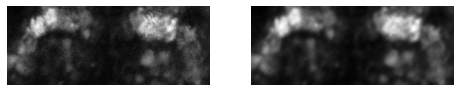

In [8]:
## Motion Correction setup
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume
# Generate reference image
reference_num = np.int_(np.round(0.1 * volume_cycle))
refImg = np.mean(stackMP[0:reference_num,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');


perform motion correction on a single plane/max projection


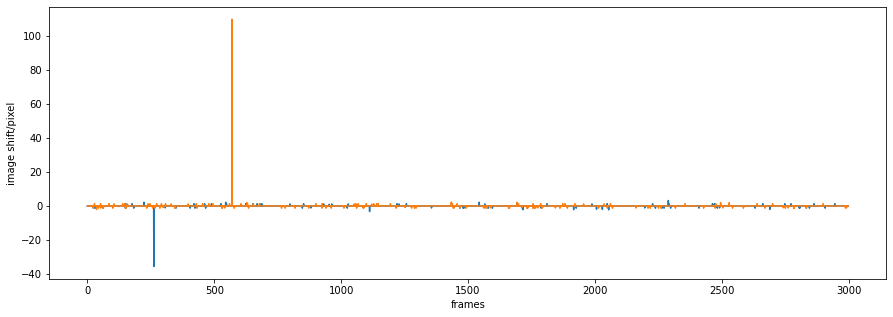

In [9]:
shift = computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

In [10]:
stack4dMC = motionCorrection(imgStack, shift)

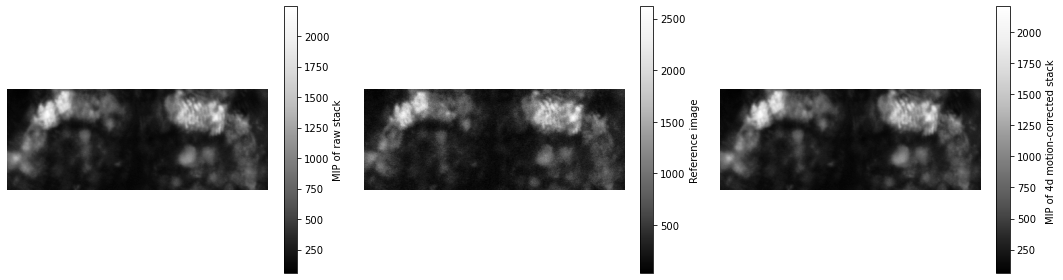

In [11]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
cb = axs[0].imshow(imgStack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

In [12]:
#new_layer = viewer.add_image(image[:,4,:,:])

In [13]:
#viewer.layers.save('my_file.csv')

In [12]:
stack4dMC.shape

(2999, 9, 150, 388)

In [1268]:
from tifffile import imsave
imsave('combine_TQfly004-001.tiff',stack4dMC)

In [13]:
label = tifffile.imread("/home/tianhaoqiu/Documents/GitHub/2p_analysis/ROI_16_combine_TQfly004-001 mean-proj.tif")
#viewer.add_labels(label, name='Labels_16_Roi')

In [14]:
#Load ROI and label from napari
#napari_roi_16 = viewer.layers['Labels_16_Roi'].data
napari_roi_16 = label[0,:,:,:]

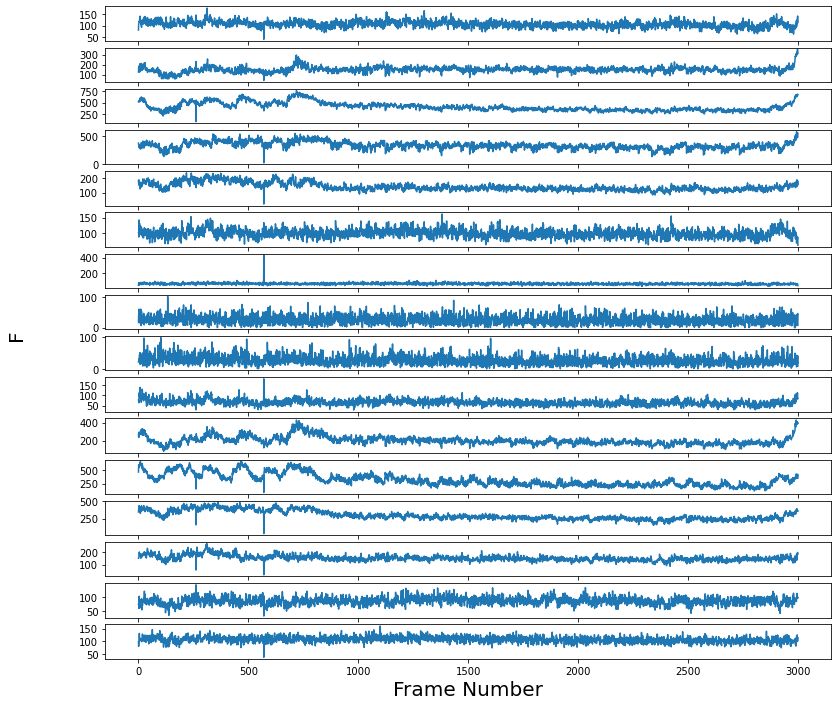

In [15]:
ROI_number = 16
F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
stack4dMC_numpy = stack4dMC.to_numpy()
for time_point in range(stack4dMC['volumes [s]'].size):
        current_volume = stack4dMC_numpy[time_point,:,:,:]
        for ROI_index in range(1, ROI_number + 1):
            mask = napari_roi_16 == ROI_index
            F_array[time_point, ROI_index - 1] =current_volume[mask].mean() 
            
fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(F_array[:,i])
fig.supylabel('F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()
    

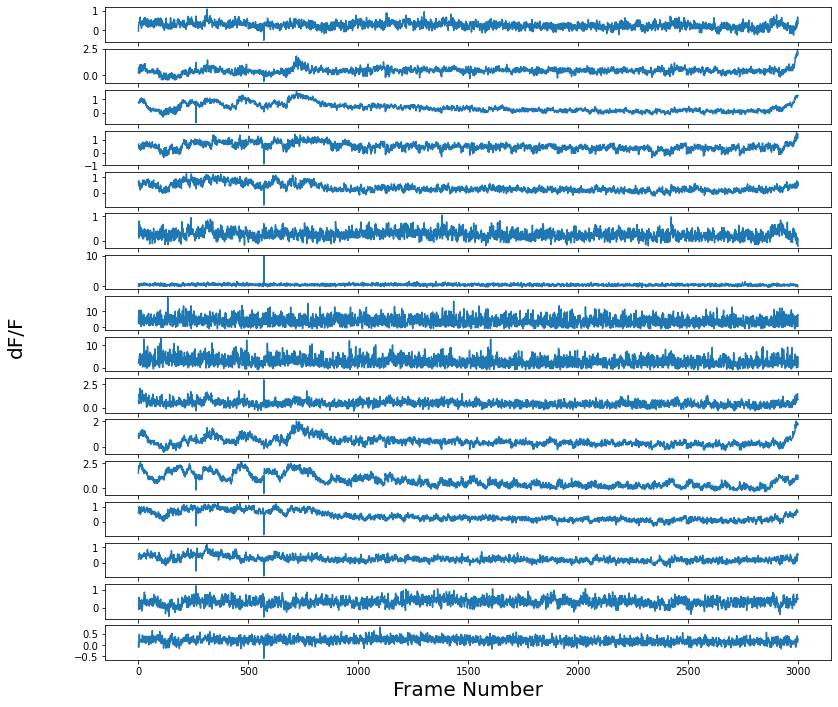

In [16]:
dF_F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
F_zero = np.quantile(F_array, 0.05, axis = 0)
for F_zero_index in range(ROI_number):
    dF_F_array[:,F_zero_index] = (F_array[:,F_zero_index] - F_zero[F_zero_index])/F_zero[F_zero_index]



fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(dF_F_array[:,i])
fig.supylabel('dF/F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

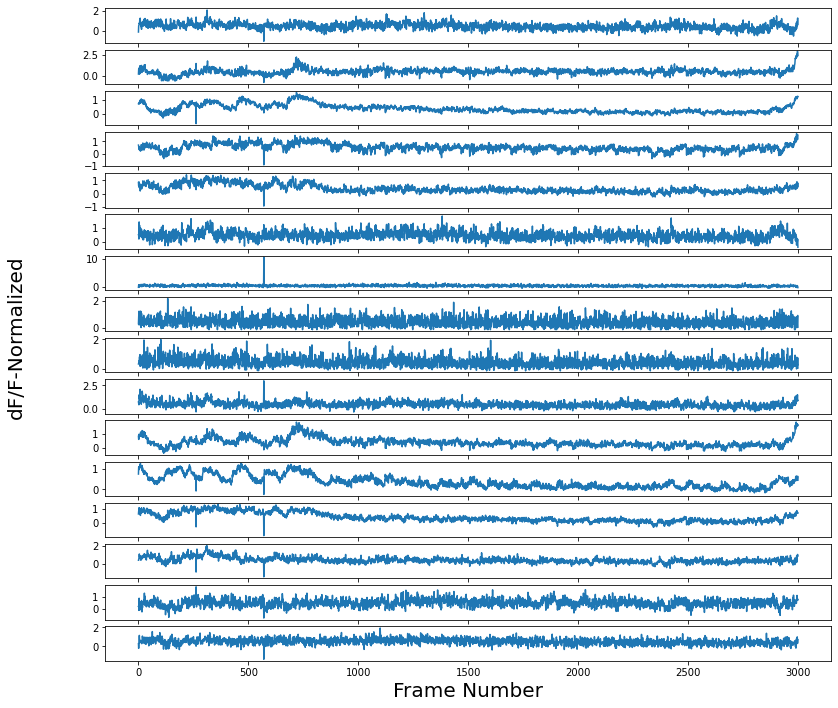

In [17]:
dF_F_array_normalized = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
dFF_95 = np.quantile(dF_F_array, 0.95, axis = 0)
for current_ROI in range(ROI_number):
    dF_F_array_normalized[:,current_ROI ] = dF_F_array[:,current_ROI ]/dFF_95[current_ROI]

fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(dF_F_array_normalized[:,i])
fig.supylabel('dF/F-Normalized',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

In [18]:
#Median_filtering the normalized df_f trace
for i in range (ROI_number):
    dF_F_array_normalized[:,i] = signal.medfilt(dF_F_array_normalized[:,i],kernel_size =3)
    

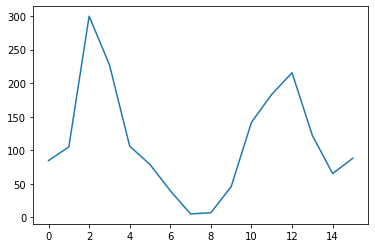

In [19]:
plt.plot(F_zero)

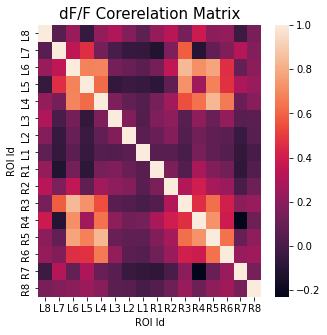

In [20]:
#Create a correlation matrix to look at the correlation between corresponding golemuruli in left/right PB
df_f_dataframe = pd.DataFrame(dF_F_array, columns=['L8', 'L7', 'L6','L5','L4','L3','L2','L1','R1','R2','R3','R4','R5','R6','R7','R8'])
correlation_matrix_df_f = df_f_dataframe.corr()
plt.figure(figsize= (5,5))
sns.heatmap(correlation_matrix_df_f)
plt.xlabel('ROI Id', fontsize=10)
plt.ylabel('ROI Id', fontsize=10)
plt.title('dF/F Corerelation Matrix', fontsize=15)
plt.show()

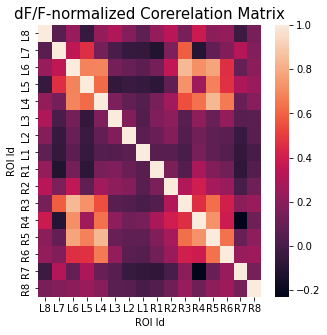

In [21]:
#Create a correlation matrix to look at the correlation between corresponding golemuruli in left/right PB
df_f_dataframe_normalized = pd.DataFrame(dF_F_array_normalized, columns=['L8', 'L7', 'L6','L5','L4','L3','L2','L1','R1','R2','R3','R4','R5','R6','R7','R8'])
correlation_matrix_df_f = df_f_dataframe.corr()
plt.figure(figsize= (5,5))
sns.heatmap(correlation_matrix_df_f)
plt.xlabel('ROI Id', fontsize=10)
plt.ylabel('ROI Id', fontsize=10)
plt.title('dF/F-normalized Corerelation Matrix', fontsize=15)
plt.show()

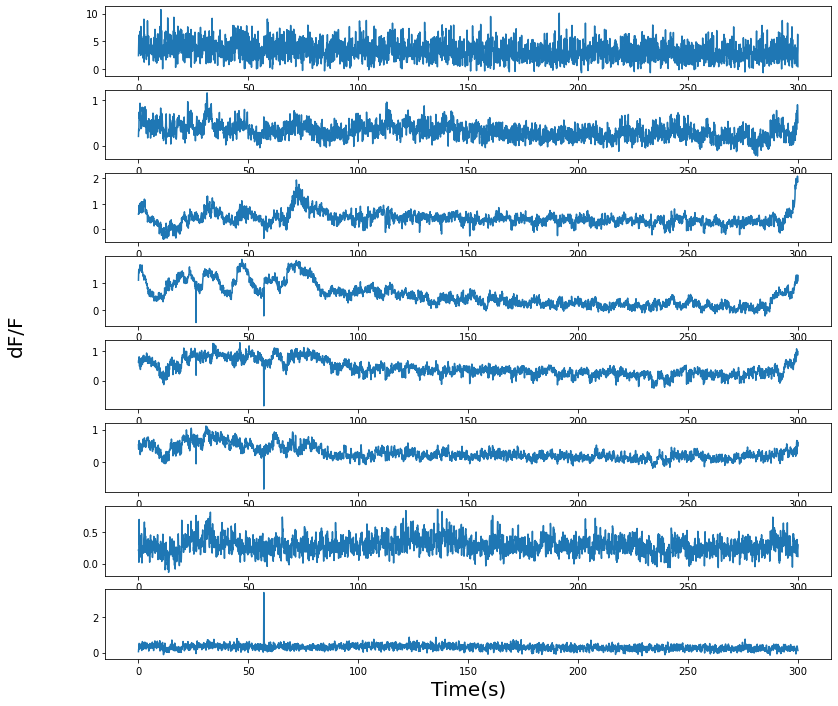

In [22]:
#Combine corresponding glomeruli in left and right PBs, leaving 8 ROIs for calculating PVA
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

ROI_number_combined = 8
dF_F_array_8_roi = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
for combined_ROI_index in range(ROI_number_combined):
    if combined_ROI_index == ROI_number_combined - 1:
        #Count pixel number to determine the weight of glomeruli L1 & R1 (And put it at first)
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 1)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        #Put it at first
        dF_F_array_8_roi[:,0] = dF_F_array[:,combined_ROI_index] * left_weight +  dF_F_array[:,combined_ROI_index + 1] * right_weight
    else:
        #Count pixel number to determine the weight of the rest of each glomeruli 
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 9)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        dF_F_array_8_roi[:,combined_ROI_index + 1] = dF_F_array[:,combined_ROI_index] * left_weight +  dF_F_array[:,combined_ROI_index + 9] * right_weight
        


fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(time_array_imaging, dF_F_array_8_roi[:,i])
fig.supylabel('dF/F',fontsize=20)
plt.xlabel('Time(s)', fontsize=20)
plt.show()

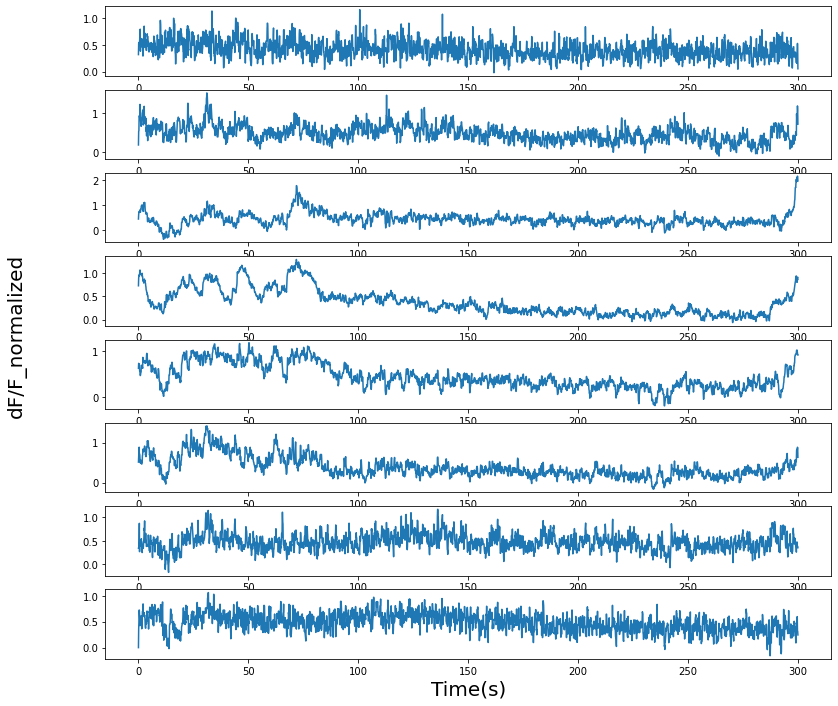

In [23]:
#Combine corresponding glomeruli in left and right PBs, leaving 8 ROIs for calculating PVA
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

ROI_number_combined = 8
dF_F_array_8_roi_normalized = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
for combined_ROI_index in range(ROI_number_combined):
    if combined_ROI_index == ROI_number_combined - 1:
        #Count pixel number to determine the weight of glomeruli L1 & R1 (And put it at first)
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 1)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        #Put it at first
        dF_F_array_8_roi_normalized[:,0] = dF_F_array_normalized[:,combined_ROI_index] * left_weight +  dF_F_array_normalized[:,combined_ROI_index + 1] * right_weight
    else:
        #Count pixel number to determine the weight of the rest of each glomeruli 
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 9)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        dF_F_array_8_roi_normalized[:,combined_ROI_index + 1] = dF_F_array_normalized[:,combined_ROI_index] * left_weight +  dF_F_array_normalized[:,combined_ROI_index + 9] * right_weight
        


fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(time_array_imaging, dF_F_array_8_roi_normalized[:,i])
fig.supylabel('dF/F_normalized',fontsize=20)
plt.xlabel('Time(s)', fontsize=20)
plt.show()

In [24]:
PVA_radian_array, PVA_strength = PVA_radian_calcul(dF_F_array_8_roi, stack4dMC['volumes [s]'].size,ROI_number_combined)
PVA_radian_array_normalized, PVA_strength_normalized = PVA_radian_calcul(dF_F_array_8_roi_normalized, stack4dMC['volumes [s]'].size,ROI_number_combined)

In [25]:
PVA_angle_Array = PVA_radian_to_angle(PVA_radian_array)
PVA_angle_Array_normalized = PVA_radian_to_angle(PVA_radian_array_normalized)

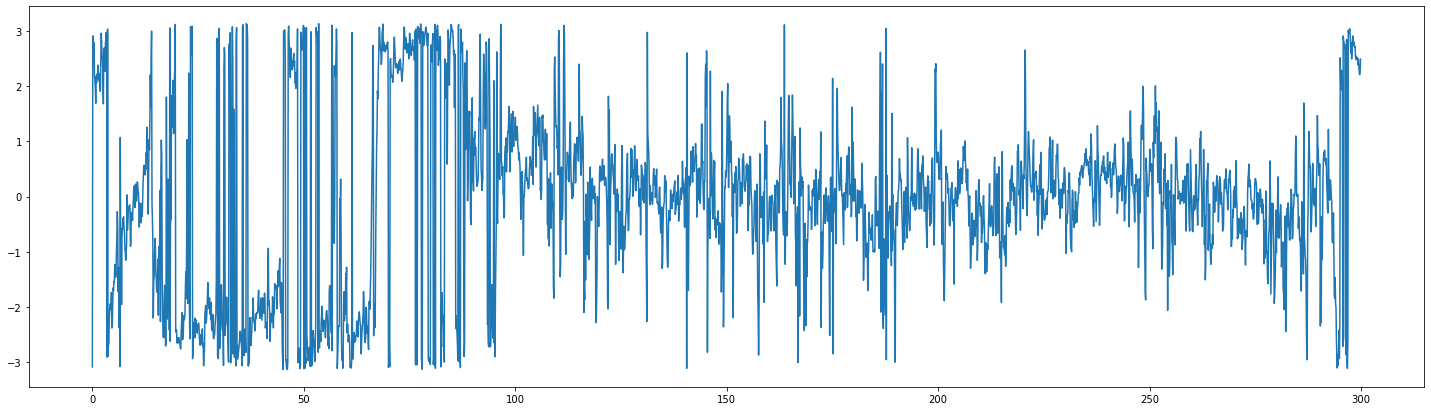

In [26]:
PVA_radian_array_new_normalized = PVA_angle_to_radian(PVA_angle_Array_normalized)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,PVA_radian_array_new_normalized)

In [27]:
PVA_ROI_assigned = PVAangleToRoi(PVA_angle_Array)
PVA_ROI_assigned_normalized = PVAangleToRoi(PVA_angle_Array_normalized)

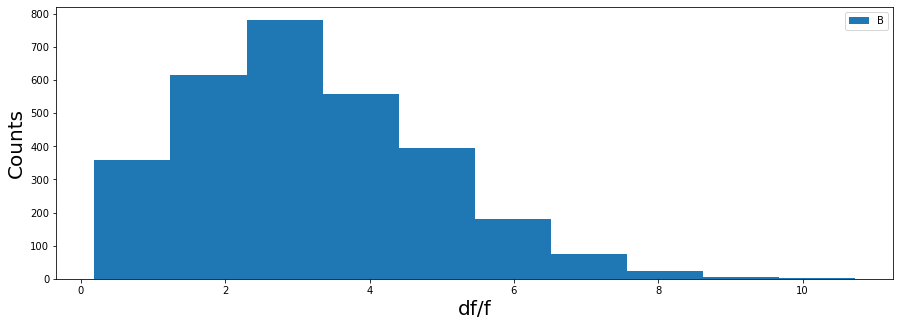

In [28]:
bump_amplitude_dff = calcualteBumpAmplitude(dF_F_array_8_roi)
plt.figure(figsize=(15,5))
plt.hist(bump_amplitude_dff)
plt.legend('Both Bridges')

plt.ylabel('Counts',fontsize=20)
plt.xlabel('df/f', fontsize=20)
plt.show()

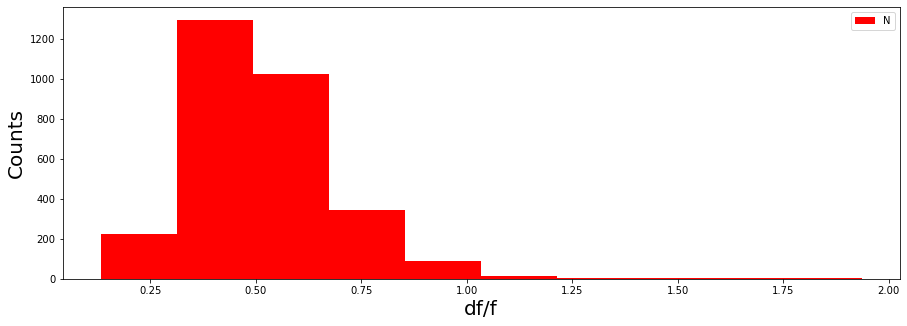

In [29]:
bump_amplitude_dff_normalized = calcualteBumpAmplitude(dF_F_array_8_roi_normalized)
plt.figure(figsize=(15,5))
plt.hist(bump_amplitude_dff_normalized, color ='r')
plt.legend('Normalized')

plt.ylabel('Counts',fontsize=20)
plt.xlabel('df/f', fontsize=20)
plt.show()

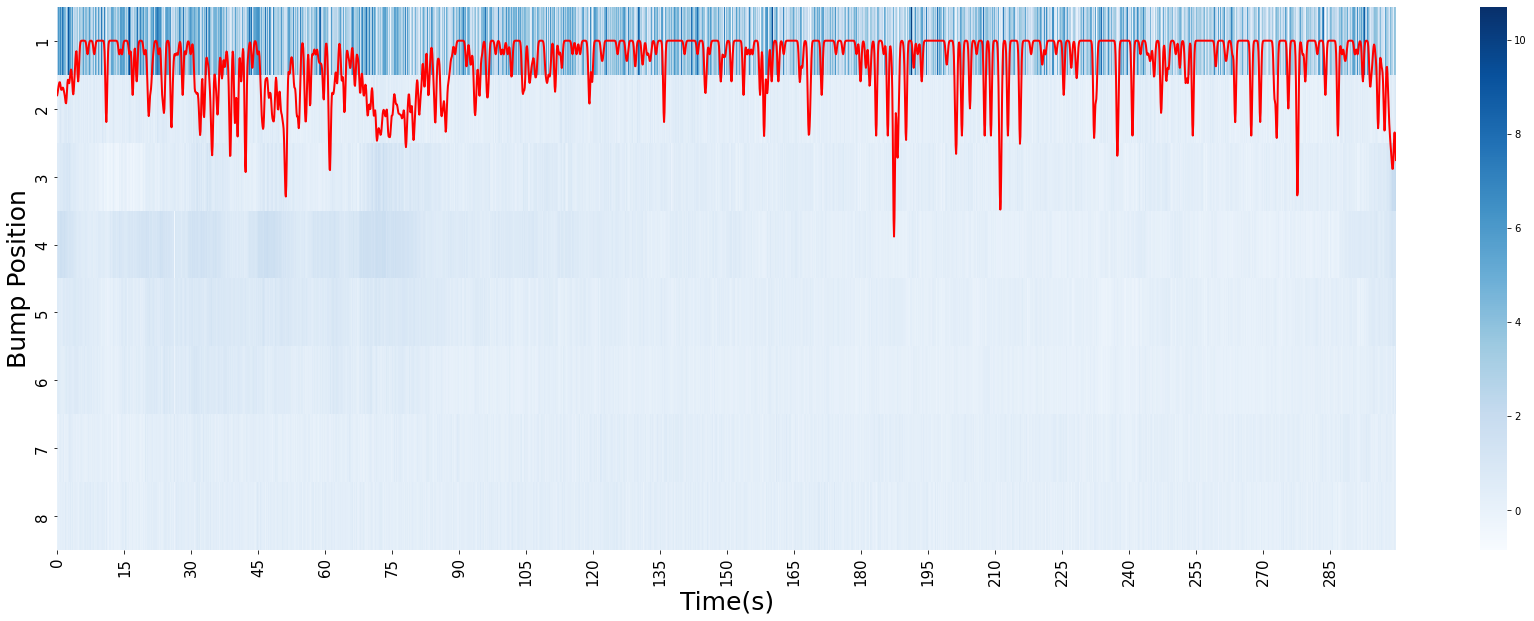

In [30]:
#Plot heatmap of signals in combined ROI and superimpose with PVA
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
df_dff_in_ROI = pd.DataFrame(dF_F_array_8_roi.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(df_dff_in_ROI , cmap='Blues', xticklabels = time_array_imaging_round)
sns.color_palette("light:b", as_cmap=True)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =15)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=15)
plt.locator_params(axis ='x',nbins = 20)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned, sigma = 2)+0.5, color='red', linewidth =2)
#sns.lineplot(data = PVA_ROI_assigned+0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

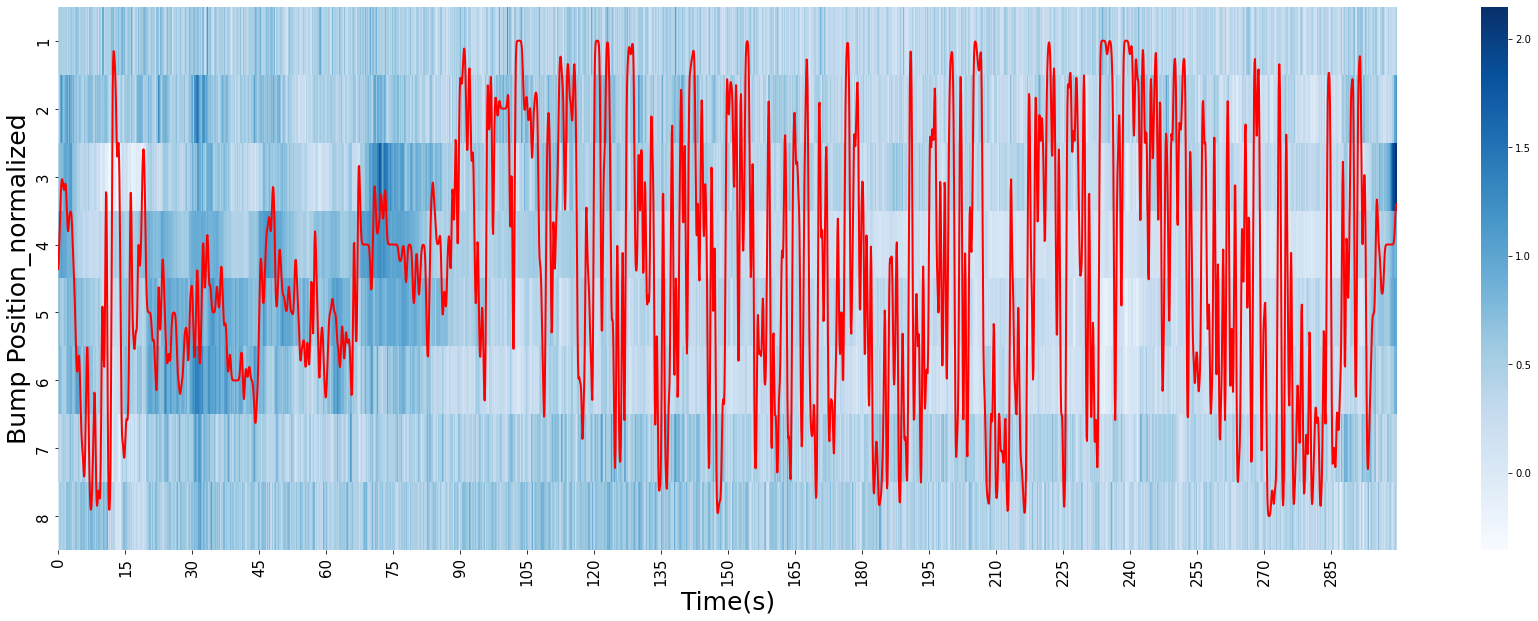

In [31]:
#Plot heatmap of signals in combined ROI and superimpose with PVA
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
df_dff_in_ROI_normalized = pd.DataFrame(dF_F_array_8_roi_normalized.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(df_dff_in_ROI_normalized , cmap='Blues', xticklabels = time_array_imaging_round)
sns.color_palette("light:b", as_cmap=True)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =15)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=15)
plt.locator_params(axis ='x',nbins = 20)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_normalized, sigma = 2)+0.5, color='red', linewidth =2)
#sns.lineplot(data = PVA_ROI_assigned+0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position_normalized', fontsize=25)
plt.show()

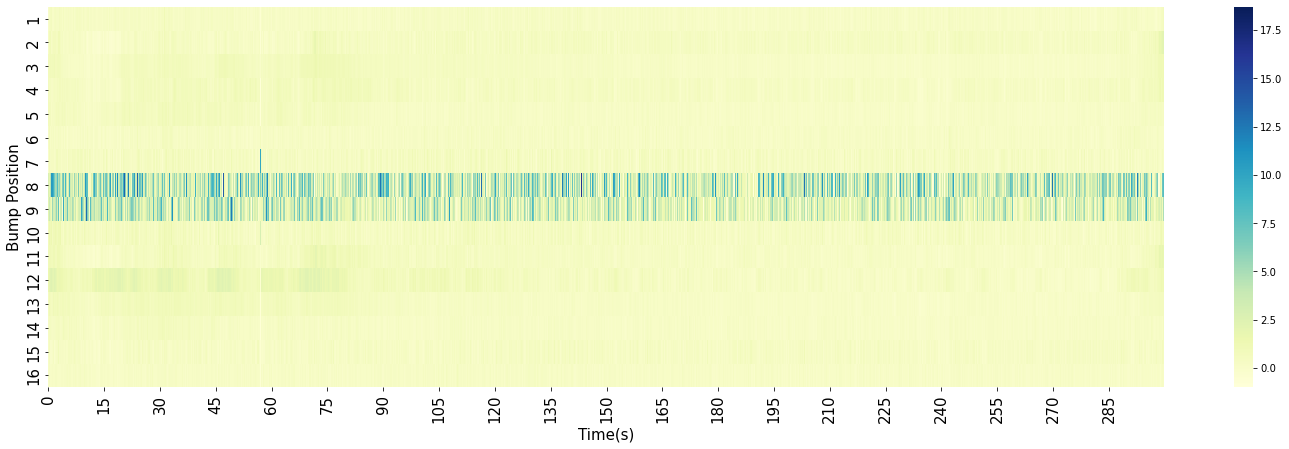

In [32]:
#Plot uncombined 16 ROi all together
plt.figure(figsize= (25,7))
p16 = sns.heatmap(dF_F_array.transpose(),cmap='YlGnBu', xticklabels = time_array_imaging_round)
sns.color_palette("light:b", as_cmap=True)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =15)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=15)
plt.locator_params(axis ='x',nbins = 20)
plt.xlabel('Time(s)', fontsize=15)
plt.ylabel('Bump Position', fontsize=15)
plt.show()

In [33]:
voltage_recording = pd.read_csv('/home/tianhaoqiu/Desktop/TQfly004-001/TQfly004-001_Cycle00001_VoltageRecording_001.csv')

In [34]:
voltage_recording 

Time(ms)   Start Trigger   Opto Trigger   FicTrac Cam Exp.  \
0              0.00        3.502502      -0.037231           0.068665   
1              0.02        4.825134       0.018005           0.071411   
2              0.04        4.964905       0.016479           0.068665   
3              0.06        4.980469       0.015259           0.070190   
4              0.08        4.984131       0.015869           0.069580   
...             ...             ...            ...                ...   
15000696  300013.92        0.019836       0.015869           0.069275   
15000697  300013.94        0.019531       0.015869           0.068970   
15000698  300013.96        0.021973       0.018005           0.070801   
15000699  300013.98        0.020447       0.016785           0.069885   
15000700  300014.00        0.020142       0.016174           0.072632   

           FicTrac Frame Proc.   Heading   Y/Index   Arena DAC1   Arena DAC2  
0                     0.020142  1.004639  0.024719     3.118286     5.086365  
1                     0.018005  1.020203  0.009766     3.117676     5.085449  
2                     0.015564  1.018677  0.009766     3.121033     5.088196  
3                     0.016785  1.019592  0.009766     3.118896     5.085449  
4                     0.015869  1.019287  0.008850     3.118591     5.086060  
...                        ...       ...       ...          ...          ...  
15000696              4.971008  9.780884  0.009155     3.119507     5.086670  
15000697              4.985352  9.781189  0.008850     3.119507     5.087280  
15000698              4.986267  9.781189  0.008850     3.116150     5.083313  
15000699              4.985657  9.780273  0.009460     3.119812     5.086060  
15000700              4.985046  9.778748  0.007629     3.119812     5.087280  

[15000701 rows x 9 columns]

In [35]:
voltage_recording_heading = voltage_recording[' Heading']

In [36]:
#Input4 = Heading, Input6 =x , Input7 =y

In [37]:
#Read the fictrac raw .dat file and trial start/end info from Bruker
fictrac_data = pd.read_table('/home/tianhaoqiu/Desktop/TQfly004-01312023/fictrac-20230131_145531.dat', sep =',', header = None, names = ['frame counter', 'delta rotation vector x (cam)', 'delta rotation vector y (cam)','delta rotation vector z (cam)','delta rotation over score', 'delta rotaion vector 1 (lab)','delta rotaion vector 2 (lab)', 'delta rotaion vector 3 (lab)', 'absolute rotation vector 1 (cam)','absolute rotation vector 2 (cam)','absolute rotation vector 3 (cam)','absolute rotation vector 1 (lab)','absolute rotation vector 2 (lab)','absolute rotation vector 3 (lab)','integrated x', 'integrated y','integrated heading','animal movement direcrtion','animal movement speed', 'integrated forward motion','integrated side motion','timestamp','sequence counter','delta timestamp','alt.timestamp'] )
fictrac_data

frame counter  delta rotation vector x (cam)  \
0                    0                       0.000000   
1                    1                       0.000466   
2                    2                       0.000419   
3                    3                       0.000739   
4                    4                      -0.000669   
...                ...                            ...   
1599885        1603845                      -0.000519   
1599886        1603846                      -0.002816   
1599887        1603847                      -0.002106   
1599888        1603848                      -0.002155   
1599889        1603849                      -0.002155   

         delta rotation vector y (cam)  delta rotation vector z (cam)  \
0                             0.000000                       0.000000   
1                             0.000893                       0.003983   
2                             0.000804                       0.003585   
3                             0.002177                       0.004033   
4                             0.001819                       0.002824   
...                                ...                            ...   
1599885                       0.003465                      -0.004013   
1599886                      -0.000318                      -0.004743   
1599887                       0.000548                      -0.003928   
1599888                       0.000501                      -0.004001   
1599889                       0.000501                      -0.004001   

         delta rotation over score  delta rotaion vector 1 (lab)  \
0                         0.000000                      0.000000   
1                      4177.172891                      0.003682   
2                      4200.912011                      0.003313   
3                      4142.814867                      0.003802   
4                      4117.735414                      0.002084   
...                            ...                           ...   
1599885                6706.233681                     -0.003916   
1599886                6791.122715                     -0.005494   
1599887                6876.011749                     -0.004476   
1599888                7130.678851                     -0.004561   
1599889                7385.345953                     -0.004561   

         delta rotaion vector 2 (lab)  delta rotaion vector 3 (lab)  \
0                            0.000000                      0.000000   
1                           -0.001485                      0.001058   
2                           -0.001336                      0.000952   
3                           -0.001261                      0.002347   
4                           -0.001924                      0.001921   
...                               ...                           ...   
1599885                      0.001480                      0.003294   
1599886                     -0.000215                     -0.000548   
1599887                      0.000026                      0.000360   
1599888                      0.000018                      0.000309   
1599889                      0.000018                      0.000309   

         absolute rotation vector 1 (cam)  absolute rotation vector 2 (cam)  \
0                                0.000000                          0.000000   
1                                0.000466                          0.000893   
2                                0.000885                          0.001697   
3                                0.001628                          0.003873   
4                                0.000964                          0.005698   
...                                   ...                               ...   
1599885                          0.423030                          1.943702   
1599886                          0.425658                          1.942407   
1599887                          0.428194                         

In [38]:
with open('/home/tianhaoqiu/Desktop/TQfly004-01312023/TQfly004_scan0.pkl', 'rb') as f:
    fictracinfo = pickle.load(f)
fictracinfo

{'start': [1119456],
 'opto': [],
 'abort': [1269240],
 'start_trig_falling_edge': [1119461]}

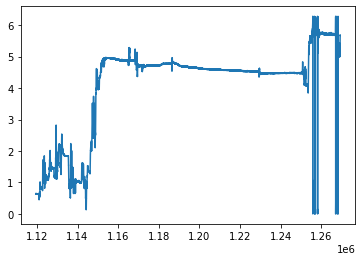

In [110]:
# the scanning start actually one frame before the falling_edge
fictrac_heading = fictrac_data['integrated heading']
fictrac_integrated_x = fictrac_data['integrated x']
fictrac_integrated_y = fictrac_data['integrated y']
plt.plot(fictrac_heading[1119460:1269240])

In [40]:
#change it to binary
fictrac_frame_proc = voltage_recording[' FicTrac Frame Proc.']
pinn_signal = np.zeros(len(fictrac_frame_proc))
for i in range(len(fictrac_frame_proc)):
    if fictrac_frame_proc[i] < 1:
        pinn_signal[i] = 0
    else:
        pinn_signal[i] = 1


(141114,)

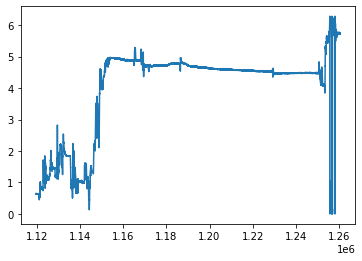

In [41]:
#find every time pinn value is up to 1(locked to each scanning frame)
up_index = np.argwhere(np.diff(pinn_signal)==1)
plt.plot(fictrac_heading[1119460:1119460+len(up_index)])
fictrac_heading[1119460:1119460+len(up_index)].shape

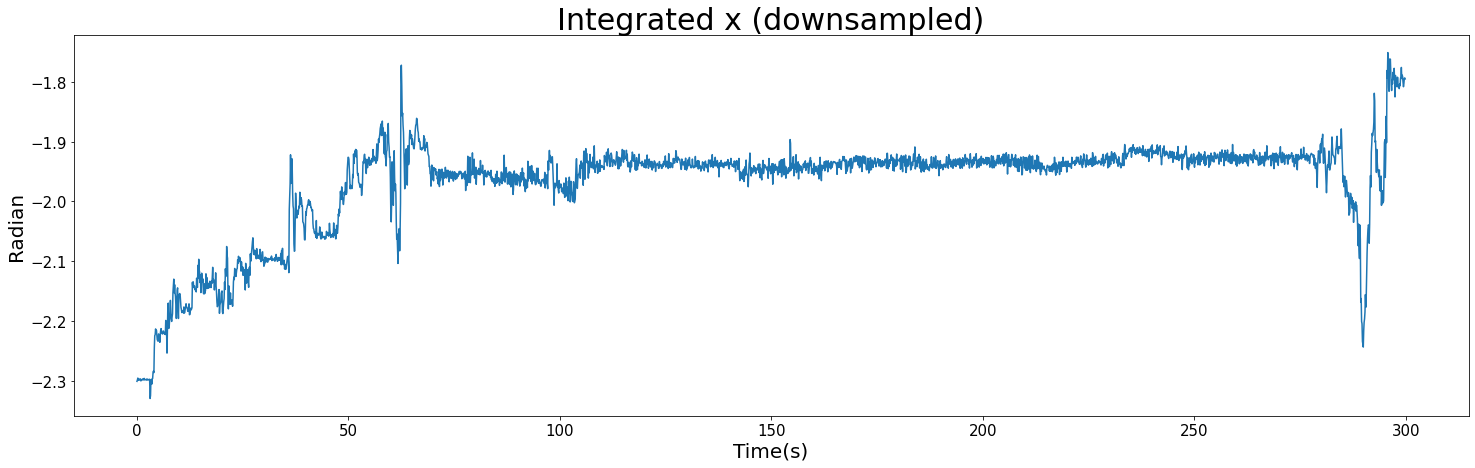

In [119]:
fictrac_integrated_x_filtered = low_pass_filter_TQ(fictrac_integrated_x[1119460:1119460+len(up_index)],100,470)
fictrac_integrated_x_filtered = low_pass_filter_TQ(fictrac_integrated_x_filtered ,100,470)
fictrac_integrated_x_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, fictrac_integrated_x_filtered)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,fictrac_integrated_x_filtered_downsampled)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.title('Integrated x (downsampled)', fontsize =30)
plt.show()

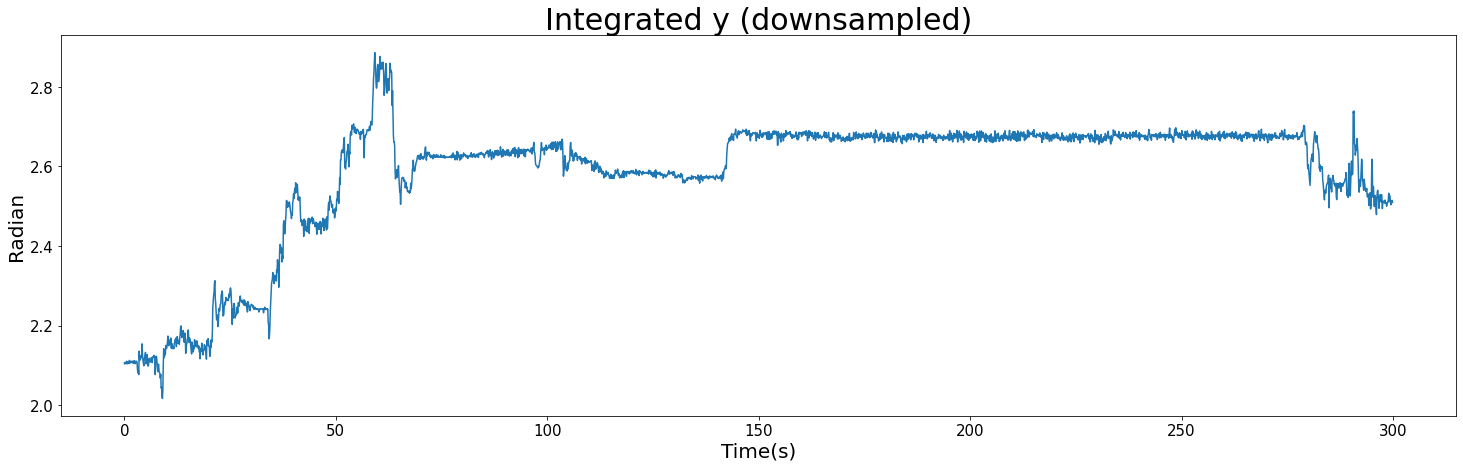

In [120]:
fictrac_integrated_y_filtered = low_pass_filter_TQ(fictrac_integrated_y[1119460:1119460+len(up_index)],100,470)
fictrac_integrated_y_filtered = low_pass_filter_TQ(fictrac_integrated_y_filtered ,100,470)
fictrac_integrated_y_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, fictrac_integrated_y_filtered)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,fictrac_integrated_y_filtered_downsampled)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.title('Integrated y (downsampled)', fontsize =30)
plt.show()

In [42]:
test = fictrac_heading[1119456:1119456+len(up_index)]

In [43]:
heading_array = voltage_recording [' Heading']
time_array_initial_fictrac = np.arange(len(heading_array))/fictrack_sampling_rate

Text(0, 0.5, 'Radian')

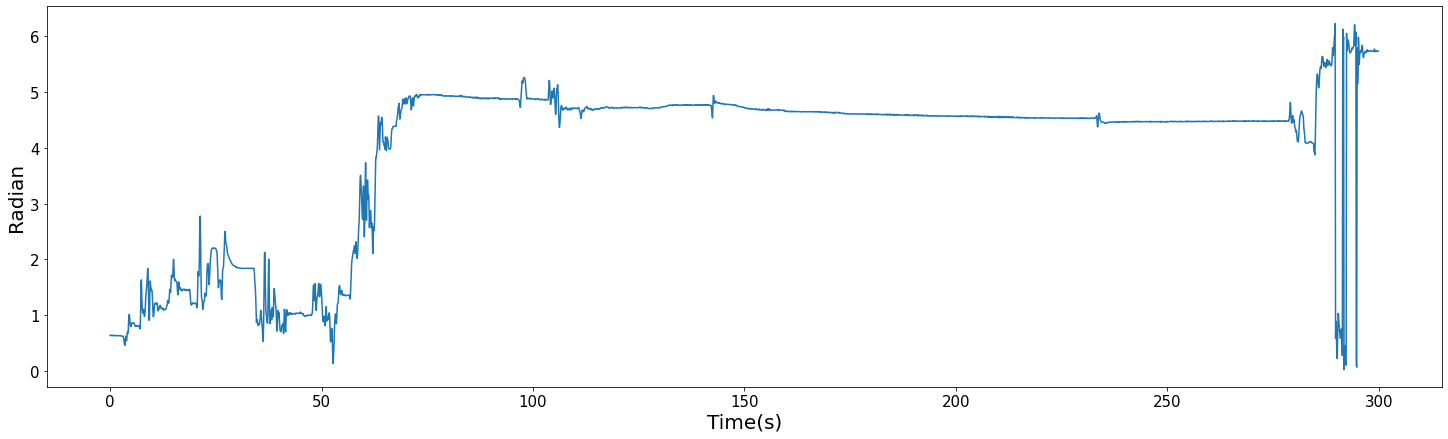

In [121]:
test_filtered = low_pass_filter_TQ(test, 100 ,470)
test_filtered = low_pass_filter_TQ(test_filtered, 100 ,470)
test_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, test_filtered)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,test_filtered_downsampled)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)

Text(0, 0.5, 'Voltage')

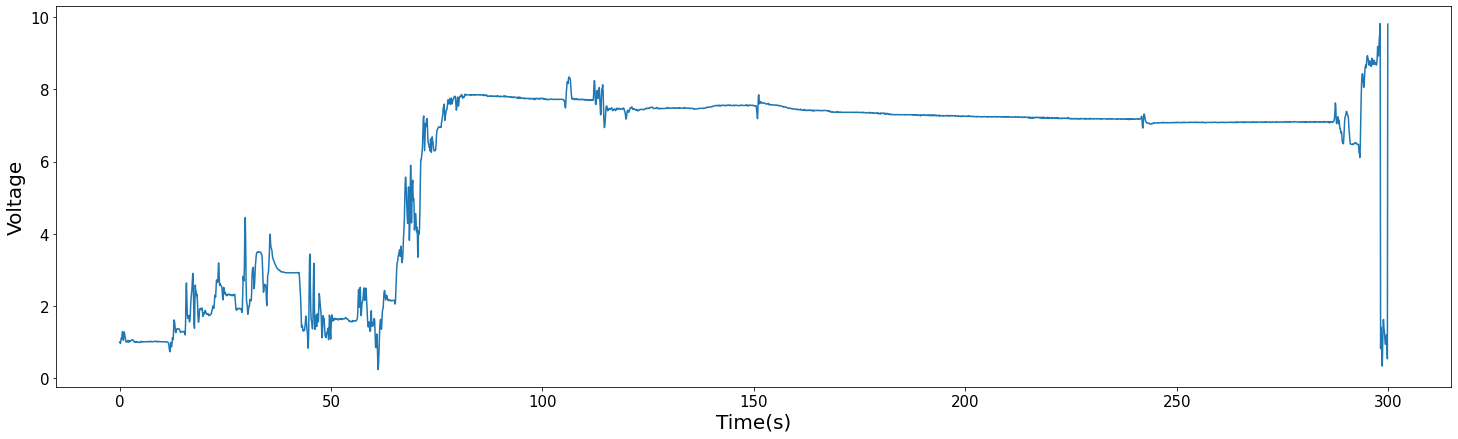

In [109]:
head_array_filtered = low_pass_filter_TQ(heading_array, 100 ,fictrack_sampling_rate)
head_array_filtered = low_pass_filter_TQ(head_array_filtered, 100 ,fictrack_sampling_rate)
head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, head_array_filtered)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,head_array_downsampled)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Voltage', fontsize=20)

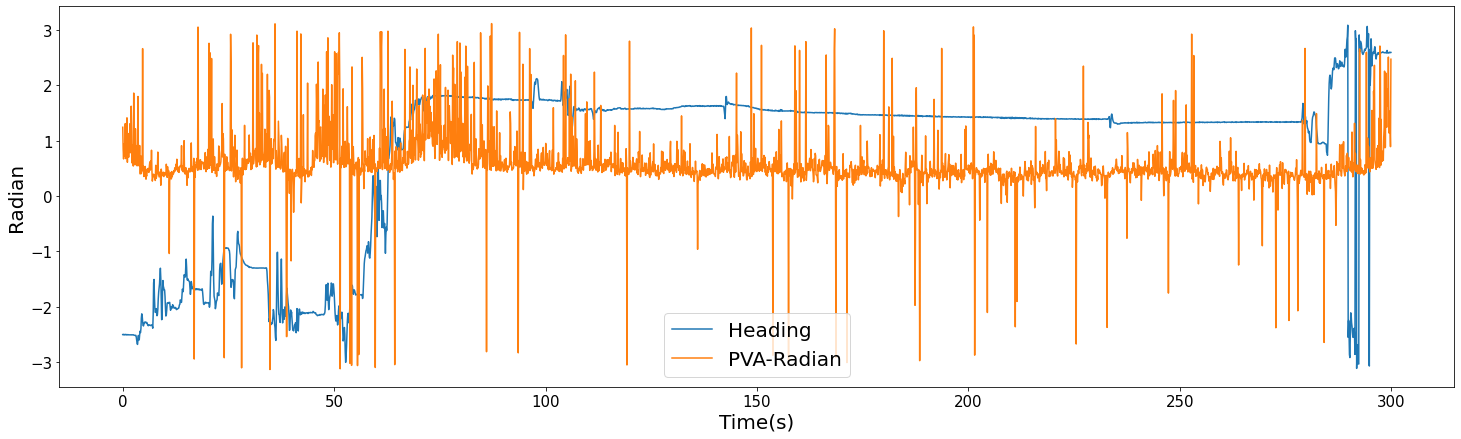

In [47]:
#0-10V equivalent to -pi to pi
#head_array_downsampled_wrapped = head_array_downsampled * np.pi*2/10 - np.pi
head_array_downsampled_wrapped = test_filtered_downsampled-np.pi
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,head_array_downsampled_wrapped)
plt.plot(time_array_imaging,PVA_radian_array)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(['Heading','PVA-Radian'],fontsize=20)

Text(0, 0.5, 'Radian Offset')

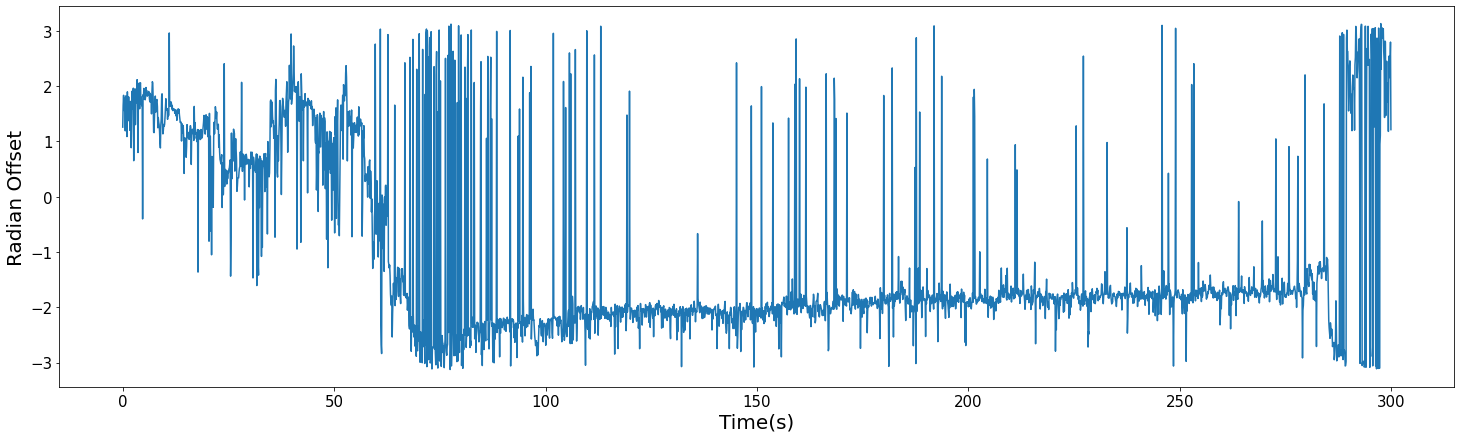

In [149]:
barPosition_array_downsampled_wrapped = -head_array_downsampled_wrapped
radian_offset = offset_calculation(barPosition_array_downsampled_wrapped, PVA_radian_array, IfRadian = True)
radian_offset_normalized = offset_calculation(barPosition_array_downsampled_wrapped, PVA_radian_array_normalized, IfRadian = True)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,radian_offset)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian Offset', fontsize=20)

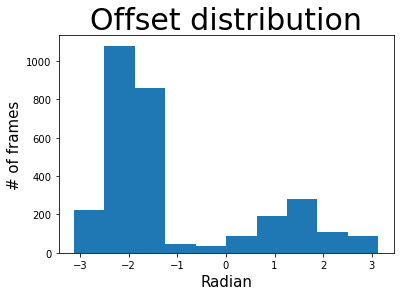

In [49]:
plt.hist(radian_offset)
plt.title('Offset distribution',fontsize=30)
plt.xlabel('Radian',fontsize=15)
plt.ylabel('# of frames',fontsize=15)
plt.show()

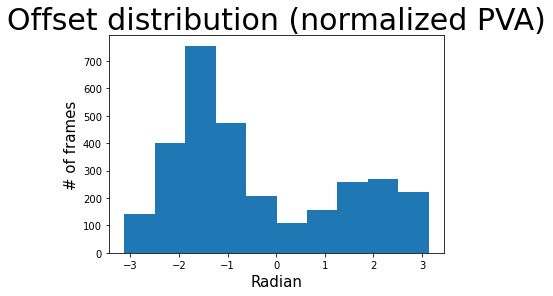

In [150]:
plt.hist(radian_offset_normalized)
plt.title('Offset distribution (normalized PVA)',fontsize=30)
plt.xlabel('Radian',fontsize=15)
plt.ylabel('# of frames',fontsize=15)
plt.show()

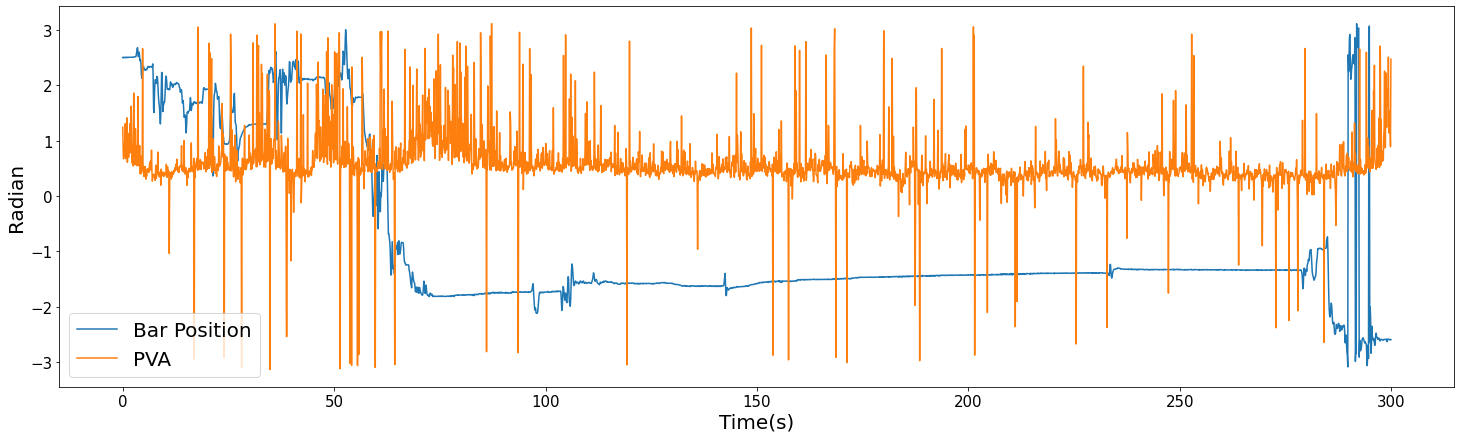

In [50]:
plt.figure(figsize= (25,7))
barPosition_diff = np.diff(barPosition_array_downsampled_wrapped)
barPosition_diff = np.concatenate([[0],barPosition_diff])
PVA_radian_array_diff = np.diff(PVA_radian_array)
PVA_radian_array_diff = np.concatenate([[0],PVA_radian_array_diff])
PVA_radian_array_plot = np.ma.masked_where(np.abs(PVA_radian_array_diff)>=6,PVA_radian_array)
barPosition_array_downsampled_wrapped_plot = np.ma.masked_where(np.abs(barPosition_diff)>=6,barPosition_array_downsampled_wrapped)
plt.plot(time_array_imaging,barPosition_array_downsampled_wrapped_plot)
plt.plot(time_array_imaging,PVA_radian_array_plot)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.legend(['Bar Position','PVA'],fontsize=20)

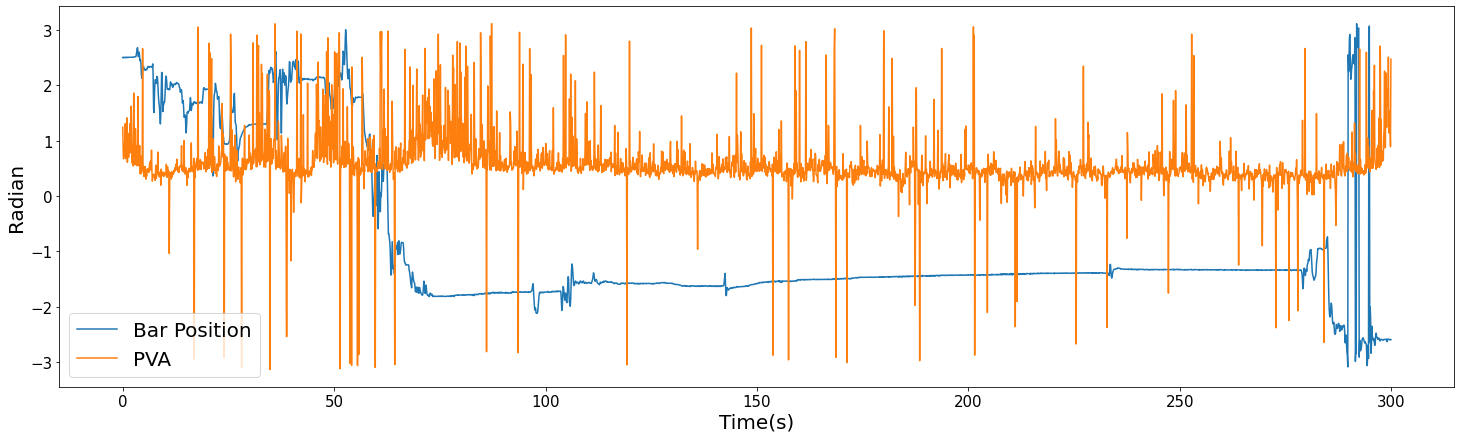

In [51]:
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,barPosition_array_downsampled_wrapped)
plt.plot(time_array_imaging,PVA_radian_array)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.legend(['Bar Position','PVA'],fontsize=20)

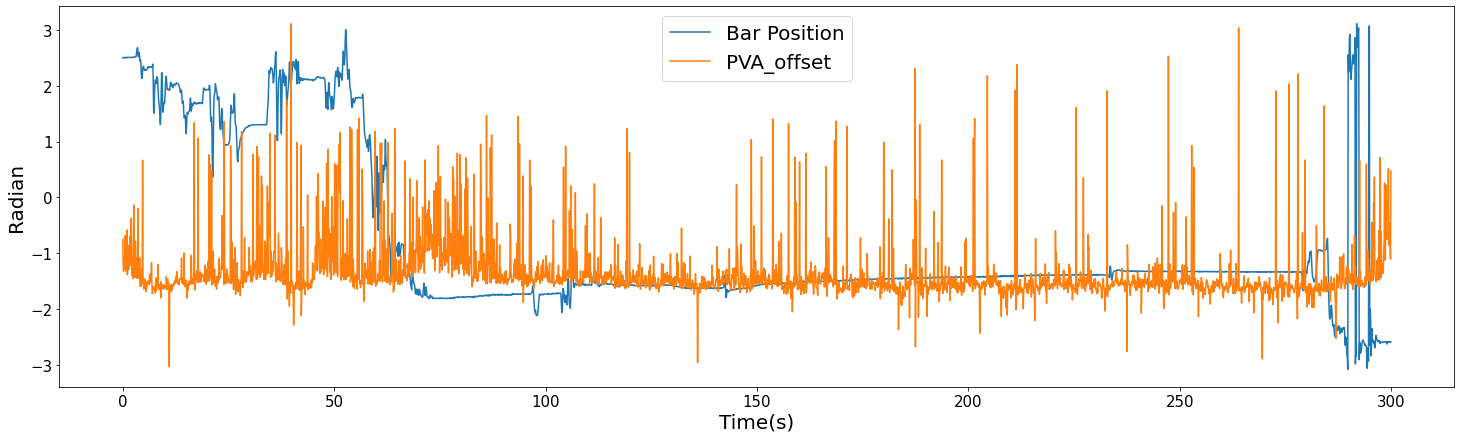

In [102]:
PVA_radian_array_offset =moving_wrapped_plot_by_offset(PVA_radian_array,math.degrees(-2), ifRadian =True)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,barPosition_array_downsampled_wrapped)
plt.plot(time_array_imaging,PVA_radian_array_offset)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.legend(['Bar Position','PVA_offset'],fontsize=20)

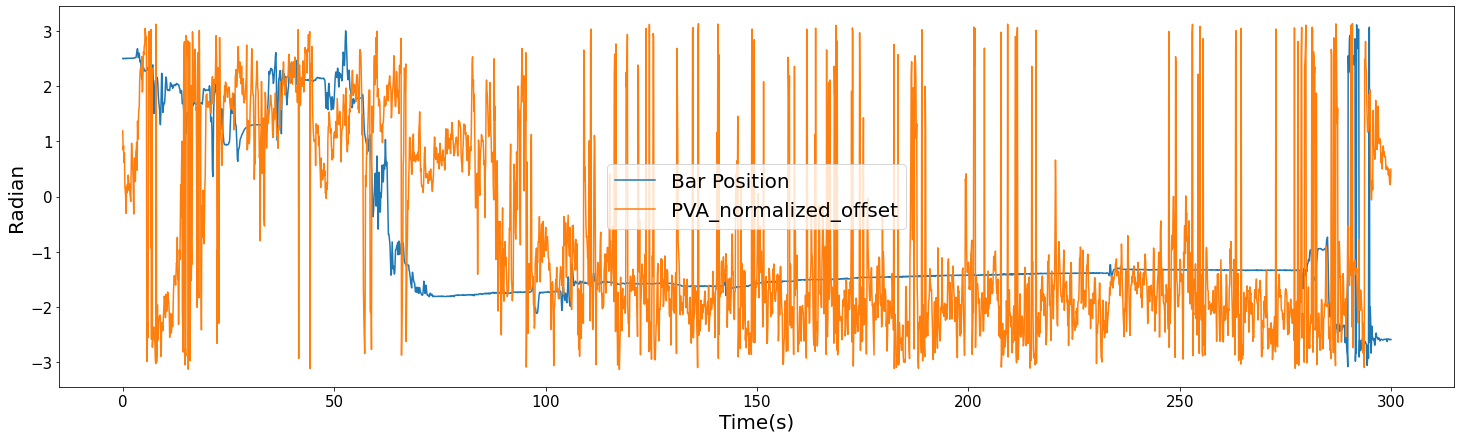

In [103]:
PVA_radian_array_normalized_offset =moving_wrapped_plot_by_offset(PVA_radian_array_normalized,math.degrees(-2), ifRadian =True)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,barPosition_array_downsampled_wrapped)
plt.plot(time_array_imaging,PVA_radian_array_normalized_offset)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.legend(['Bar Position','PVA_normalized_offset'],fontsize=20)

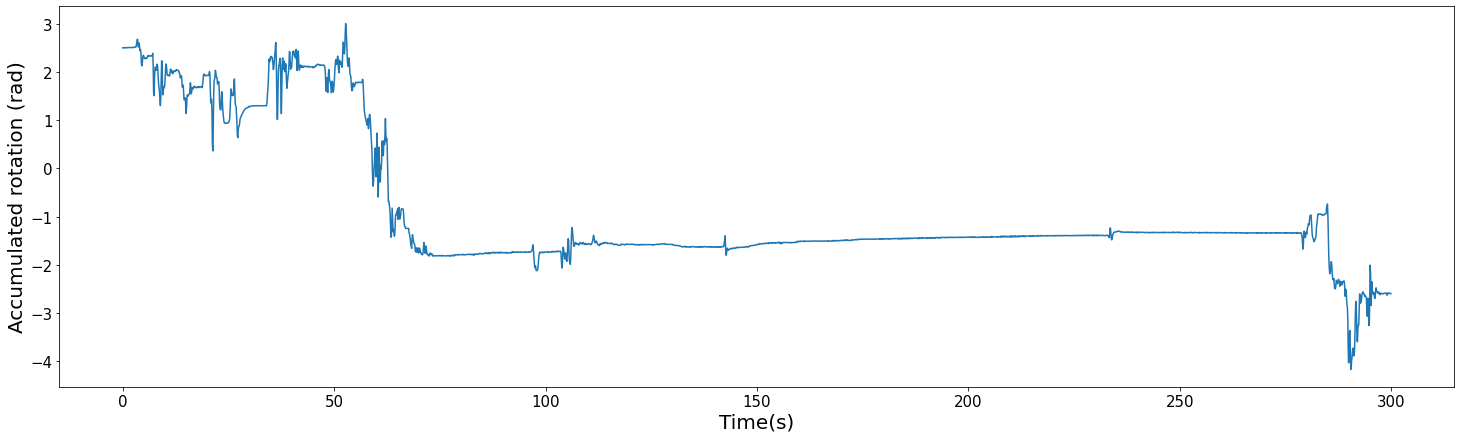

In [54]:
max_Voltage = 10
#heading_array_processed = fictrack_signal_decoding(barPosition_array_downsampled_wrapped, time_array_imaging, max_Voltage, already_radian = True)
heading_array_processed = fictrack_signal_decoding(barPosition_array_downsampled_wrapped, time_array_imaging, max_Voltage, already_radian = True)

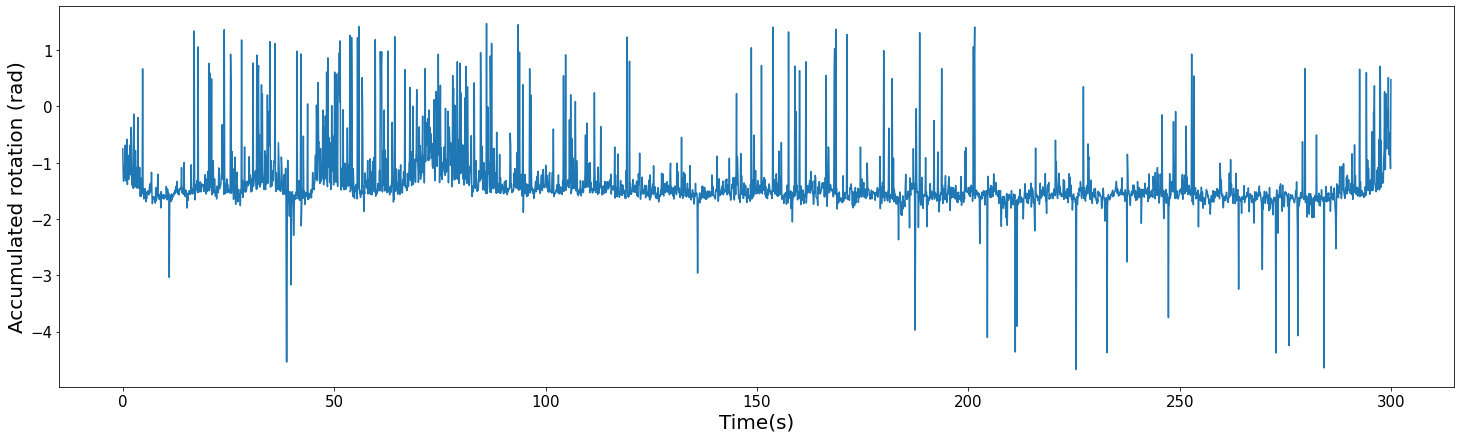

In [104]:
PVA_unwrapped = fictrack_signal_decoding(PVA_radian_array_offset, time_array_imaging, max_voltage = 10, already_radian = True)

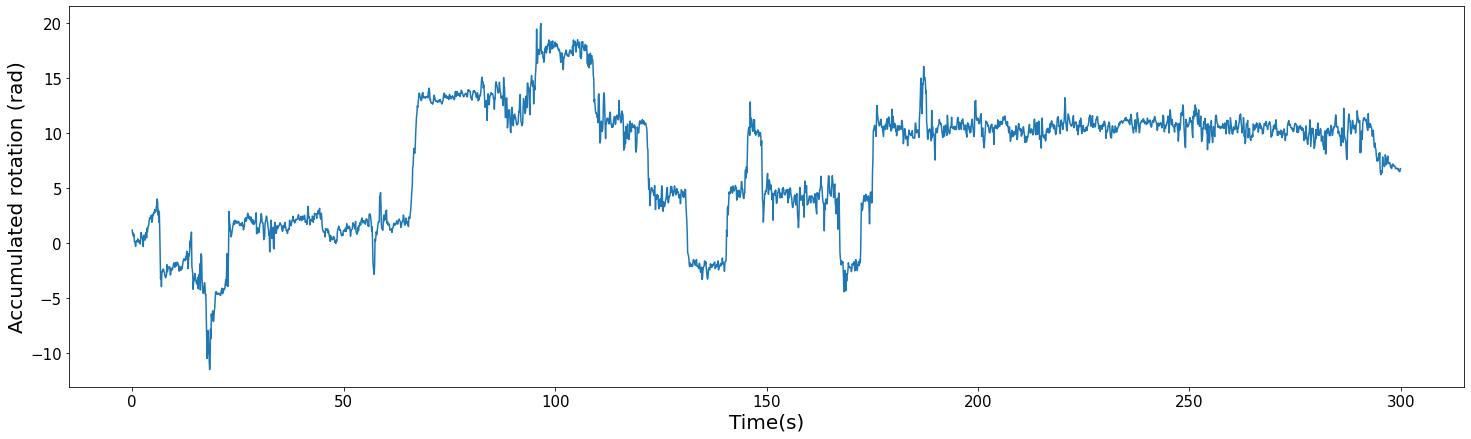

In [125]:
PVA_unwrapped_normalized = fictrack_signal_decoding(PVA_radian_array_normalized_offset, time_array_imaging, max_voltage = 10, already_radian = True)

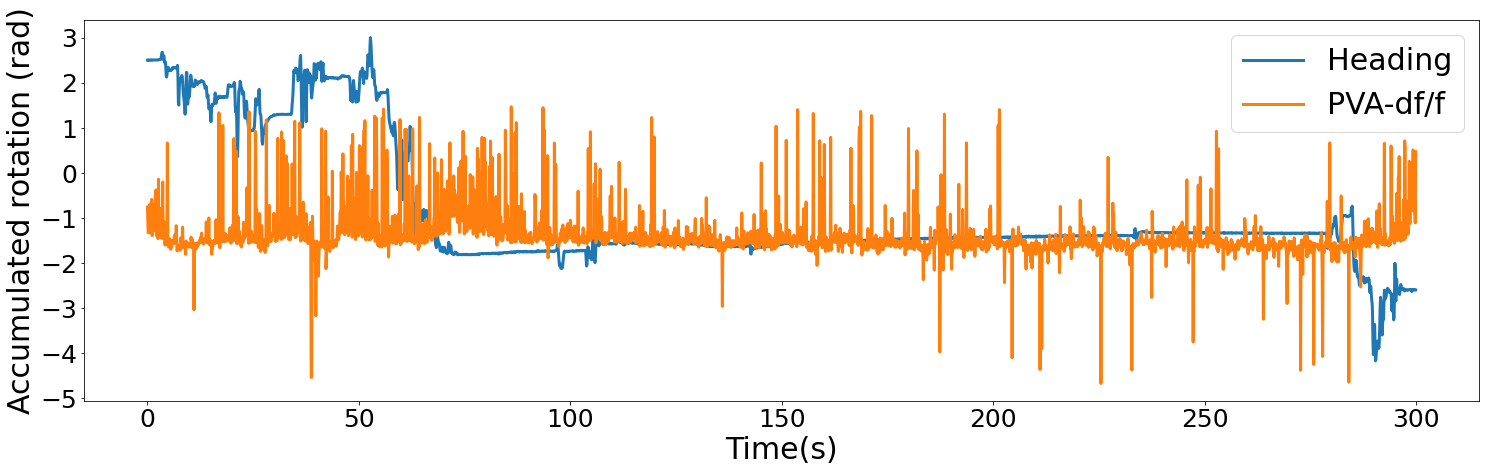

In [106]:
#head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, heading_array_processed)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped,linewidth =3)
plt.xlabel('Time(s)', fontsize=30)
plt.ylabel('Accumulated rotation (rad)', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(['Heading','PVA-df/f'],fontsize=30)
plt.show()

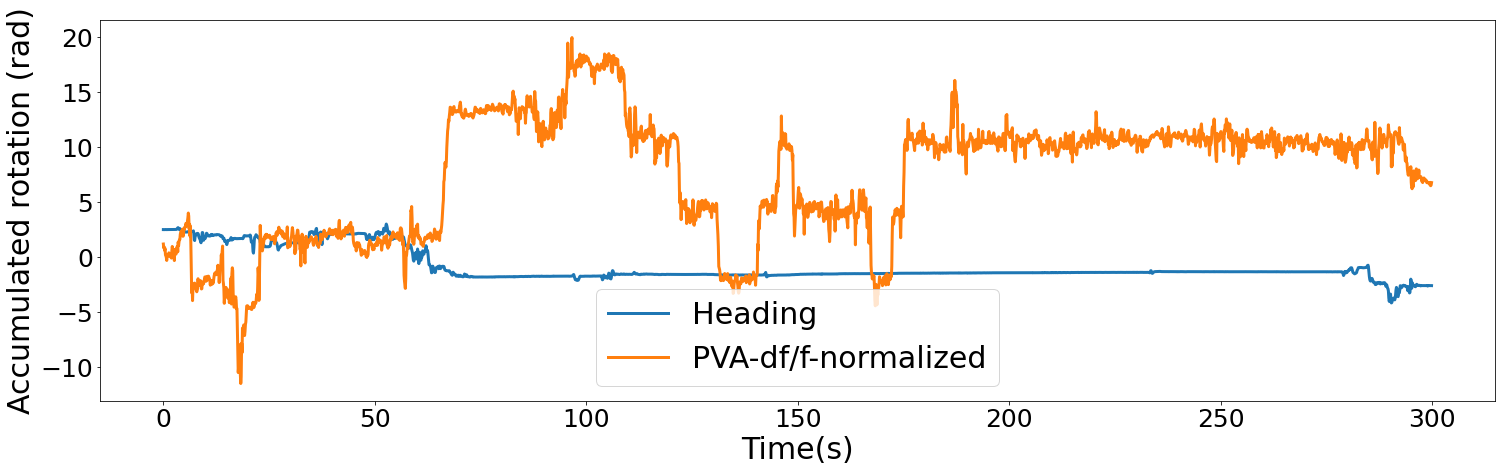

In [107]:
#head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, heading_array_processed)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped_normalized,linewidth =3)
plt.xlabel('Time(s)', fontsize=30)
plt.ylabel('Accumulated rotation (rad)', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(['Heading','PVA-df/f-normalized'],fontsize=30)
plt.show()

In [59]:
#Create a dataframe to contain all different ways calculating unwrapped PVA and/or amplitudes
all_pva_data = pd.DataFrame()
all_pva_data['Heading'] = heading_array_processed 
all_pva_data['PVA_radian_dff'] = PVA_unwrapped 
all_pva_data['PVA_radian_dff_normalized'] = PVA_unwrapped_normalized
#all_pva_data['PVA_radian_dff_sgfiltered'] = PVA_unwrapped_sgfiltered
#all_pva_data['PVA_radian_dff_left_only'] = PVA_unwrapped_dff_left_only
#all_pva_data['PVA_radian_dff_right_only'] =  PVA_unwrapped_dff_right_only
#all_pva_data['PVA_radian_z'] = PVA_unwrapped_z
#all_pva_data['PVA_radian_z_left_only'] = PVA_unwrapped_z_left_only 
#all_pva_data['PVA_radian_z_right_only'] = PVA_unwrapped_z_right_only 
all_pva_data['Bump_amplitude'] = bump_amplitude_dff
#all_pva_data['Bump_amplitude_left_only'] = bump_amplitude_dff_left_only
#all_pva_data['Bump_amplitude_right_only'] = bump_amplitude_dff_right_only
all_pva_data['Heading_velocity'] = np.gradient(heading_array_processed)/volume_time
all_pva_data['PVA_dff_velocity'] = np.gradient(all_pva_data['PVA_radian_dff'])/volume_time
#all_pva_data['PVA_dff_velocity_sgfiltered'] = np.gradient(all_pva_data['PVA_radian_dff_sgfiltered'])/volume_time
#all_pva_data['PVA_dff_left_only_velocity'] = np.gradient(all_pva_data['PVA_radian_dff_left_only'])/volume_time
#all_pva_data['PVA_dff_right_only_velocity'] = np.gradient(all_pva_data['PVA_radian_dff_right_only'])/volume_time
#all_pva_data['PVA_z_velocity'] = np.gradient(all_pva_data['PVA_radian_z'])
#all_pva_data['PVA_z_left_only_velocity'] = np.gradient(all_pva_data['PVA_radian_z_left_only'])
#all_pva_data['PVA_z_right_only_velocity'] = np.gradient(all_pva_data['PVA_radian_z_right_only'])
all_pva_data

Heading  PVA_radian_dff  PVA_radian_dff_normalized  Bump_amplitude  \
0     2.503203       -0.756508                  -3.092791        2.337652   
1     2.500759       -1.152293                  -3.443416        3.959476   
2     2.506482       -1.328968                  -3.364601        6.069075   
3     2.500736       -1.060577                  -3.669080        2.311349   
4     2.507234       -1.210606                  -3.492869        3.850236   
...        ...             ...                        ...             ...   
2994 -2.598188       -0.863059                   2.357195        3.539988   
2995 -2.594007       -0.466584                   2.250763        2.297897   
2996 -2.598385       -0.742883                   2.213406        3.385506   
2997 -2.592160       -1.107157                   2.273087        6.082698   
2998 -2.595080        0.473544                   2.495983        1.758877   

      Heading_velocity  PVA_dff_velocity  
0            -0.024433         -3.956667  
1             0.016393         -2.861444  
2            -0.000113          0.458442  
3             0.003758          0.591633  
4             0.038588         -1.065114  
...                ...               ...  
2994         -0.038174          0.703730  
2995         -0.000982          0.600700  
2996          0.009233         -3.201903  
2997          0.016521          6.080310  
2998         -0.029191         15.802266  

[2999 rows x 6 columns]

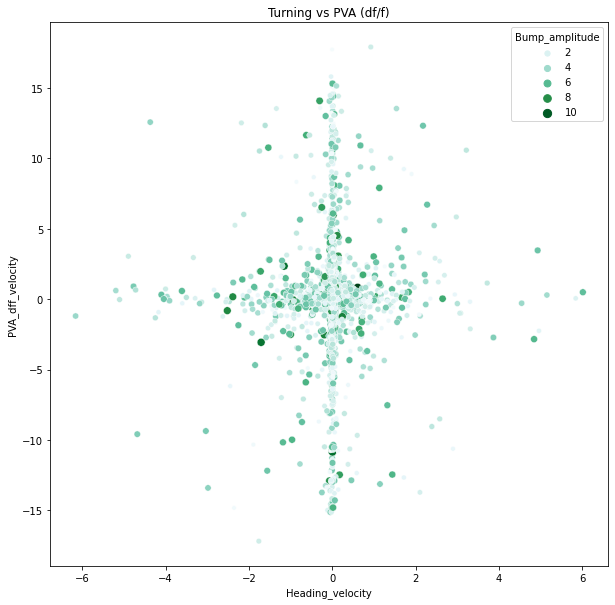

In [60]:
plt.figure(figsize=(10, 10))
plt.title('Turning vs PVA (df/f)')
sns.scatterplot(data = all_pva_data, y = 'PVA_dff_velocity', x = 'Heading_velocity', hue = 'Bump_amplitude', size = 'Bump_amplitude', palette = 'BuGn')
plt.show()


In [61]:
#Calculate velocity and generate correlation matrix of PVA and Heading
def calculate_PVA_heading_velocity_corr(heading_array, PVA_array, volume_time, bump_amplitude):
    heading_velocity = np.gradient(heading_array)/volume_time
    PVA_velocity = np.gradient(PVA_array)/volume_time
    
    abnormal_velocity = np.argwhere(np.absolute(PVA_velocity) > 8.72)
    while (len(abnormal_velocity ) > 0):
        PVA_velocity[abnormal_velocity ] = PVA_velocity[abnormal_velocity -1]
        abnormal_velocity = np.argwhere(np.absolute(PVA_velocity) > 8.72)
    
    abnormal_velocity = np.argwhere(np.absolute(heading_velocity) > 8.72)
    while (len(abnormal_velocity ) > 0):
        heading_velocity[abnormal_velocity ] = heading_velocity[abnormal_velocity -1]
        abnormal_velocity = np.argwhere(np.absolute(heading_velocity) > 8.72)
    
    velocity_corr_array = np.zeros([heading_array.size, 3])
    velocity_corr_array[:,0]=heading_velocity
    velocity_corr_array[:,1]=PVA_velocity
    #gaussian_window = signal.windows.gaussian(5,0.6)
    #velocity_corr_array[:,0]= np.convolve (velocity_corr_array[:,0], gaussian_window, mode = 'same')
    #velocity_corr_array[:,1]= np.convolve (velocity_corr_array[:,1], gaussian_window, mode = 'same')
    velocity_corr_array[:,2]=bump_amplitude
    
    import seaborn as sns
    import pandas as pd
    df = pd.DataFrame(velocity_corr_array, columns = ['Turning Velocity', 'PVA Velocity', 'PVA Amplitude_green'])
    sns.scatterplot(data = df, x='Turning Velocity', y='PVA Velocity')
    plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 10)
    plt.ylabel('PVA Velocity (Rad/Sec)', fontsize = 10)    
    return df['PVA Velocity'], df['Turning Velocity'], df

0.020292803359577206

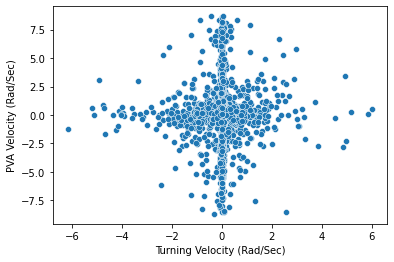

In [63]:
PVA_vel, Heading_vel, velocity_df = calculate_PVA_heading_velocity_corr(heading_array_processed, PVA_unwrapped, volume_time=volume_time, bump_amplitude= bump_amplitude_dff)
np.corrcoef(PVA_vel,Heading_vel)[0,1]

0.024512311519899604

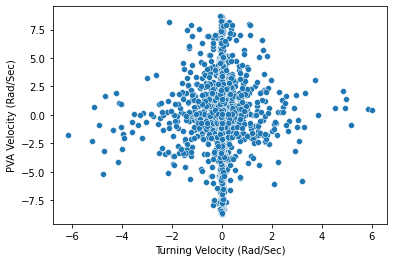

In [64]:
PVA_vel_normalized, Heading_vel, velocity_df = calculate_PVA_heading_velocity_corr(heading_array_processed, PVA_unwrapped_normalized, volume_time=volume_time, bump_amplitude= bump_amplitude_dff_normalized)
np.corrcoef(PVA_vel_normalized,Heading_vel)[0,1]

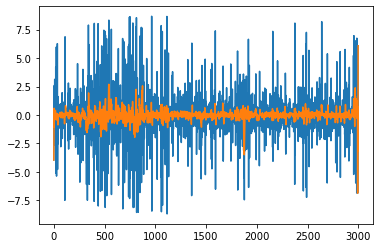

In [65]:
PVA_vel_avt = averaging_frame(PVA_vel, 10)
plt.plot(PVA_vel)
plt.plot(PVA_vel_avt)

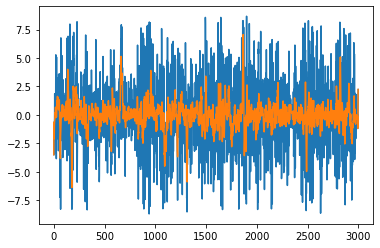

In [66]:
PVA_vel_avt_normalized = averaging_frame(PVA_vel_normalized, 10)
plt.plot(PVA_vel_normalized)
plt.plot(PVA_vel_avt_normalized)

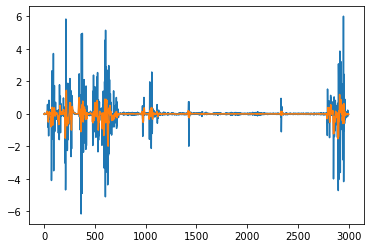

In [67]:
Heading_vel_avt = averaging_frame(Heading_vel, 10)
plt.plot(Heading_vel)
plt.plot(Heading_vel_avt)

-0.0034541831466959935

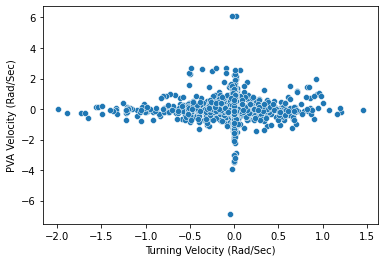

In [68]:
sns.scatterplot(x =Heading_vel_avt, y=PVA_vel_avt)
plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 10)
plt.ylabel('PVA Velocity (Rad/Sec)', fontsize = 10)  
np.corrcoef(PVA_vel_avt,Heading_vel)[0,1]

0.01788960164848648

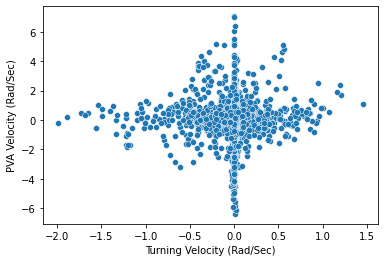

In [69]:
sns.scatterplot(x =Heading_vel_avt, y=PVA_vel_avt_normalized)
plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 10)
plt.ylabel('PVA Velocity (Rad/Sec)', fontsize = 10)  
np.corrcoef(PVA_vel_avt_normalized,Heading_vel)[0,1]

In [70]:
#Maximum velocity 500 degree/s in radians
turningVel_threshold_up = 8.72
pvaVel_threshold_up = 8.72
#About 12 degrees/s in radians transformed from green 1mm/s on 6.35mm diameter ball
turningVel_threshold_down = 0.21
pvaVel_threshold_down = 0.21
amplitude_threshold = 0.8

In [71]:
cross_correlated_turning_velocity_dff_both_Bridges = Heading_vel_avt
cross_correlated_PVA_velocity_dff_both_Bridges = PVA_vel_avt
cc_turningVel_dff_BB_cleared = []
cc_PVAVel_dff_BB_cleared = []
for i in range(len(cross_correlated_turning_velocity_dff_both_Bridges)):
    if all([np.abs(cross_correlated_turning_velocity_dff_both_Bridges[i]) > turningVel_threshold_down, np.abs(cross_correlated_PVA_velocity_dff_both_Bridges[i]) > pvaVel_threshold_down, np.abs(cross_correlated_turning_velocity_dff_both_Bridges[i]) < turningVel_threshold_up, np.abs(cross_correlated_PVA_velocity_dff_both_Bridges[i]) < pvaVel_threshold_up]):
        cc_turningVel_dff_BB_cleared.append(cross_correlated_turning_velocity_dff_both_Bridges[i])
        cc_PVAVel_dff_BB_cleared.append(cross_correlated_PVA_velocity_dff_both_Bridges[i])

In [72]:
np.corrcoef(cc_turningVel_dff_BB_cleared, cc_PVAVel_dff_BB_cleared)[0, 1]

0.052770018512818165

<AxesSubplot:xlabel='Turning_velocity', ylabel='Bump_velocity'>

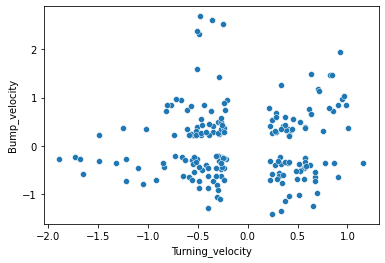

In [73]:
velocity_correlation_processed = pd.DataFrame()
velocity_correlation_processed['Turning_velocity'] = cc_turningVel_dff_BB_cleared
velocity_correlation_processed['Bump_velocity'] = cc_PVAVel_dff_BB_cleared
sns.scatterplot(data = velocity_correlation_processed, y = 'Bump_velocity', x = 'Turning_velocity')

In [74]:
def shift_for_maximum_correlation(x, y, max_shift_frame):
    
    from scipy.signal import correlate
    from scipy.signal import correlation_lags

    correlation = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
                                  
    #find the middle index to consider the frame on both side till max shift frame (1s)
    middle_index = int(len(lags)/2)
    lags_short = lags[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
    correlation_short = correlation[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
    lag = lags_short[np.argmax(correlation_short)]
    #Lag > 0 means turning velocity is being shifted back and vice versa.
    if lag < 0:
        y = y.iloc[abs(lag):].reset_index(drop=True)
    else:
        x = x.iloc[lag:].reset_index(drop=True)
    return x, y, lag

In [75]:
velocity_df['Turning Velocity'] = Heading_vel_avt
velocity_df['PVA Velocity'] = PVA_vel_avt

Text(0.5, 1.0, 'Correlation after shifting,lag equals 0.30008999999999997 s, R = 0.03630127231176493')

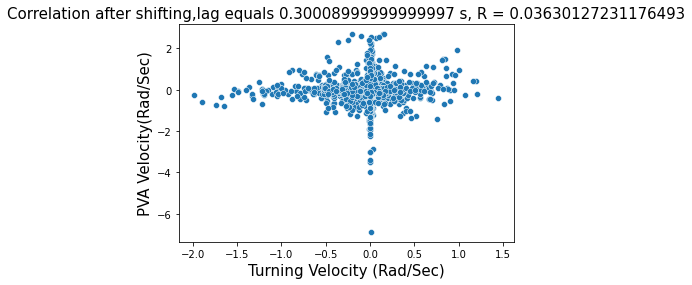

In [76]:
shifted_x, shifted_y, lagframe = shift_for_maximum_correlation(velocity_df['Turning Velocity'], velocity_df['PVA Velocity'], max_shift_frame = round(volume_rate)-1) 
shortest = min(shifted_x.shape[0], shifted_y.shape[0])
np.corrcoef(shifted_x.iloc[:shortest].values, shifted_y.iloc[:shortest].values)[0, 1]
velocity_crosscorrelated = pd.concat([shifted_x.iloc[:shortest], shifted_y.iloc[:shortest]], axis=1, join='inner')
import seaborn as sns
sns.scatterplot(data = velocity_crosscorrelated, x='Turning Velocity', y='PVA Velocity')
plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 15)
plt.ylabel('PVA Velocity(Rad/Sec)', fontsize = 15)  
plt.title(f"Correlation after shifting,lag equals {lagframe * volume_time} s, R = {np.corrcoef(shifted_x.iloc[:shortest].values, shifted_y.iloc[:shortest].values)[0, 1]}", fontsize = 15)

In [77]:
if lagframe < 0:
    bump_amplitude_dff_green_shifted = velocity_df['PVA Amplitude_green'].iloc[abs(lagframe):].reset_index(drop=True)
else:
    bump_amplitude_dff_green_shifted = velocity_df['PVA Amplitude_green']
bump_amplitude_dff_green_shifted = bump_amplitude_dff_green_shifted.iloc[:shortest].values

In [78]:
#Maximum velocity 500 degree/s in radians (8,72)
turningVel_threshold_up = np.pi * 2
pvaVel_threshold_up = np.pi* 2
#About 12 degrees/s in radians transformed from green 1mm/s on 6.35mm diameter ball
turningVel_threshold_down = 0.21
pvaVel_threshold_down = 0.21
amplitude_threshold = 0.8

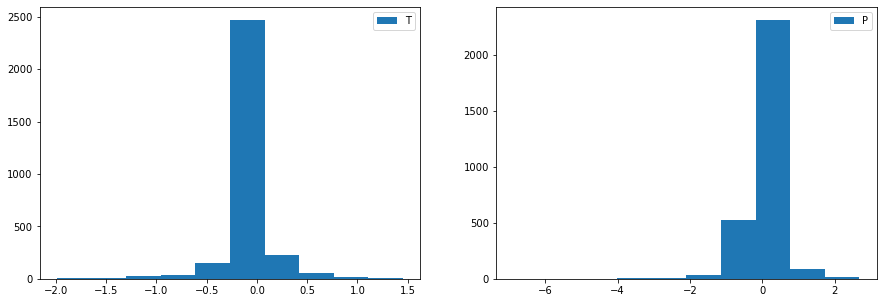

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.hist(shifted_x.iloc[:shortest].values)
ax.legend('Turning Velocity')
ax = axs[1]
ax.hist(shifted_y.iloc[:shortest].values)
ax.legend('PVA Velocity')

In [80]:
cross_correlated_turning_velocity_dff_both_Bridges = shifted_x.iloc[:shortest].values
cross_correlated_PVA_velocity_dff_both_Bridges = shifted_y.iloc[:shortest].values
cc_turningVel_dff_BB_cleared = []
cc_PVAVel_dff_BB_cleared = []
for i in range(len(cross_correlated_turning_velocity_dff_both_Bridges)):
    if np.abs(cross_correlated_turning_velocity_dff_both_Bridges[i]) > turningVel_threshold_down and np.abs(cross_correlated_PVA_velocity_dff_both_Bridges[i]) > pvaVel_threshold_down and np.abs(cross_correlated_turning_velocity_dff_both_Bridges[i]) < turningVel_threshold_up and np.abs(cross_correlated_PVA_velocity_dff_both_Bridges[i]) < pvaVel_threshold_up and bump_amplitude_dff_green_shifted[i] > amplitude_threshold:
        cc_turningVel_dff_BB_cleared.append(cross_correlated_turning_velocity_dff_both_Bridges[i])
        cc_PVAVel_dff_BB_cleared.append(cross_correlated_PVA_velocity_dff_both_Bridges[i])
    

In [81]:
np.corrcoef(cc_turningVel_dff_BB_cleared, cc_PVAVel_dff_BB_cleared)[0, 1]

0.48342410003447617

0.48342410003447617

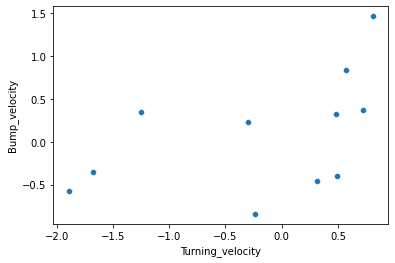

In [82]:
velocity_correlation_processed = pd.DataFrame()
velocity_correlation_processed['Turning_velocity'] = cc_turningVel_dff_BB_cleared
velocity_correlation_processed['Bump_velocity'] = cc_PVAVel_dff_BB_cleared
sns.scatterplot(data = velocity_correlation_processed, x = 'Turning_velocity', y = 'Bump_velocity',  palette = 'BuGn')
np.corrcoef(cc_turningVel_dff_BB_cleared, cc_PVAVel_dff_BB_cleared)[0, 1]

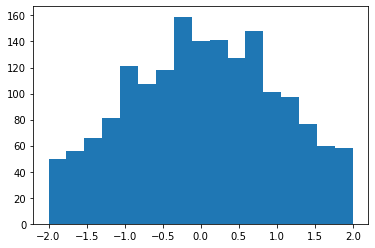

In [83]:
Heading_vel_degree = Heading_vel * 180/np.pi
plt.hist(Heading_vel_degree, bins='auto', range = (-2,2))
plt.show()

In [87]:
np.quantile(np.abs(Heading_vel_degree),0.05)

0.12785193146319856

In [128]:
PVA_behavior_data_output_original = pd.DataFrame()
PVA_behavior_data_output_original['dFF_Roi_1'] = dF_F_array_8_roi[:,0]
PVA_behavior_data_output_original['dFF_Roi_2'] = dF_F_array_8_roi[:,1]
PVA_behavior_data_output_original['dFF_Roi_3'] = dF_F_array_8_roi[:,2]
PVA_behavior_data_output_original['dFF_Roi_4'] = dF_F_array_8_roi[:,3]
PVA_behavior_data_output_original['dFF_Roi_5'] = dF_F_array_8_roi[:,4]
PVA_behavior_data_output_original['dFF_Roi_6'] = dF_F_array_8_roi[:,5]
PVA_behavior_data_output_original['dFF_Roi_7'] = dF_F_array_8_roi[:,6]
PVA_behavior_data_output_original['dFF_Roi_8'] = dF_F_array_8_roi[:,7]
PVA_behavior_data_output_original['PVA_Radian'] = PVA_radian_array
PVA_behavior_data_output_original['PVA_Radian_offset'] = PVA_radian_array_offset
PVA_behavior_data_output_original['PVA_Angle'] = PVA_angle_Array
PVA_behavior_data_output_original['Angular_Velocity'] = Heading_vel
PVA_behavior_data_output_original['Bar_Position/Heading'] = barPosition_array_downsampled_wrapped
PVA_behavior_data_output_original['Unwrapped_Bar_Position/Heading'] = heading_array_processed
PVA_behavior_data_output_original['Unwrapped_Radian'] = PVA_unwrapped
PVA_behavior_data_output_original['Integrated_x'] = fictrac_integrated_x_filtered_downsampled
PVA_behavior_data_output_original['Integrated_y'] = fictrac_integrated_y_filtered_downsampled
PVA_behavior_data_output_original['PVA_strength'] = PVA_strength
PVA_behavior_data_output_original['Bump_amplitude'] = bump_amplitude_dff

In [132]:
PVA_behavior_data_output_original.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/original/TQfly004-001-imaging.csv',encoding = 'utf-8', index=False)

In [129]:
PVA_behavior_data_output_normalized = pd.DataFrame()
PVA_behavior_data_output_normalized['dFF_Roi_1'] = dF_F_array_8_roi_normalized[:,0]
PVA_behavior_data_output_normalized['dFF_Roi_2'] = dF_F_array_8_roi_normalized[:,1]
PVA_behavior_data_output_normalized['dFF_Roi_3'] = dF_F_array_8_roi_normalized[:,2]
PVA_behavior_data_output_normalized['dFF_Roi_4'] = dF_F_array_8_roi_normalized[:,3]
PVA_behavior_data_output_normalized['dFF_Roi_5'] = dF_F_array_8_roi_normalized[:,4]
PVA_behavior_data_output_normalized['dFF_Roi_6'] = dF_F_array_8_roi_normalized[:,5]
PVA_behavior_data_output_normalized['dFF_Roi_7'] = dF_F_array_8_roi_normalized[:,6]
PVA_behavior_data_output_normalized['dFF_Roi_8'] = dF_F_array_8_roi_normalized[:,7]
PVA_behavior_data_output_normalized['PVA_Radian'] = PVA_radian_array_normalized
PVA_behavior_data_output_normalized['PVA_Radian_offset'] = PVA_radian_array_normalized_offset
PVA_behavior_data_output_normalized['PVA_Angle'] = PVA_angle_Array_normalized
PVA_behavior_data_output_normalized['Angular_Velocity'] = Heading_vel
PVA_behavior_data_output_normalized['Bar_Position/Heading'] = barPosition_array_downsampled_wrapped
PVA_behavior_data_output_normalized['Unwrapped_Bar_Position/Heading'] = heading_array_processed
PVA_behavior_data_output_normalized['Unwrapped_Radian'] = PVA_unwrapped_normalized
PVA_behavior_data_output_normalized['Integrated_x'] = fictrac_integrated_x_filtered_downsampled
PVA_behavior_data_output_normalized['Integrated_y'] = fictrac_integrated_y_filtered_downsampled
PVA_behavior_data_output_normalized['PVA_strength'] = PVA_strength_normalized
PVA_behavior_data_output_normalized['Bump_amplitude'] = bump_amplitude_dff_normalized

In [153]:
PVA_angle_Array_normalized

array([-177.20386703,  162.70677747,  167.22257466, ...,  126.81883279,
        130.23831699,  143.00927629])

In [133]:
PVA_behavior_data_output_normalized.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/TQfly004-001-imaging-normalized.csv',encoding = 'utf-8', index=False)

In [144]:
def find_stop_period_on_heading(head_velocity_array,degree_of_tolerance,shortest_stopFrame):
    radian_cutoff = degree_of_tolerance * np.pi/180
    stop_index = []
    stop_length = []
    count = 0
    
    for current_volume in range(len(head_velocity_array)):
        #Special case for last index in the array
        if current_volume == len(head_velocity_array) -1:
            if np.abs(head_velocity_array[current_volume]) < radian_cutoff:
                count = count + 1
                if count >= shortest_stopFrame:
                    stop_index.append(current_volume)
                    stop_length.append(count)
            elif count >= shortest_stopFrame:
                stop_index.append(current_volume-1)
                stop_length.append(count)               
        elif current_volume < len(head_velocity_array) -1:
            if np.abs(head_velocity_array[current_volume]) < radian_cutoff:
                count = count + 1
            elif count < shortest_stopFrame:
                count = 0
            else:
                stop_index.append(current_volume-1)
                stop_length.append(count)
                count = 0
    
    stop_index_length_combined = np.zeros((len(stop_index),2))
    stop_index_length_combined[:,0] = stop_index
    stop_index_length_combined[:,1] = stop_length
    stop_index_length_combined = stop_index_length_combined.astype(int)
    return stop_index_length_combined
        

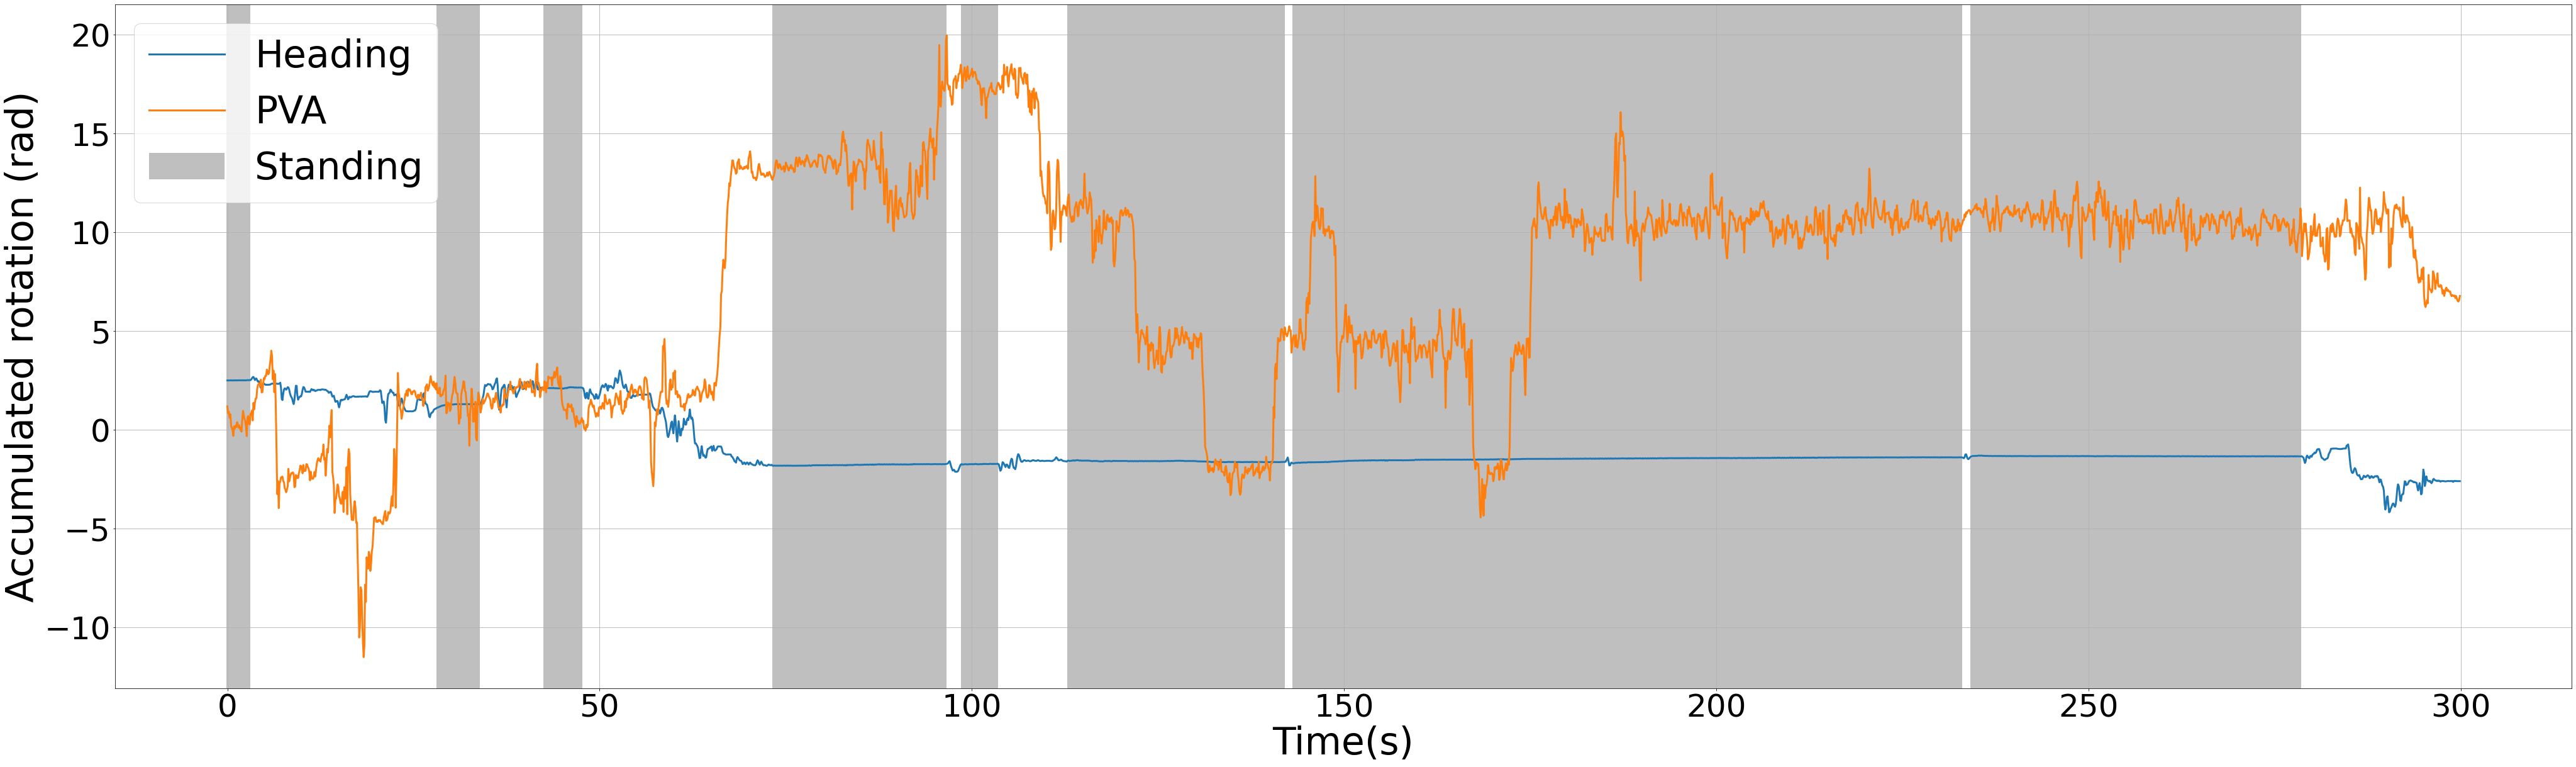

In [146]:
persistence_stop_index_and_length = find_stop_period_on_heading(Heading_vel,degree_of_tolerance =10,shortest_stopFrame=25)
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped_normalized,linewidth =3)
plt.xlabel('Time(s)', fontsize=60)
plt.ylabel('Accumulated rotation (rad)', fontsize=60)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.legend(['Heading','PVA','Standing'],fontsize=60)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.grid()
plt.show()

In [748]:
#PVA1 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/cl_trial/PVA_7f_12222022_1245_027.csv')
#PVA2 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/cl_trial/PVA_7f_12222022_1245_028.csv')
#PVA3 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/cl_trial/PVA_7f_12082022_1335_011.csv')
#PVA4 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/cl_trial/PVA_7f_12062022_1421_011.csv')
#PVA5 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/cl_trial/PVA_7f_12062022_1421_012.csv')
PVA6 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/cl_trial/PVA_8S_11242022_1355_009.csv')
PVA7 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/cl_trial/PVA_8S_11242022_1355_011.csv')
PVA8 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/cl_trial/PVA_8S_11192022_1318_002.csv')
PVA9 = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/PVA/cl_trial/PVA_8S_11192022_1318_003.csv')
PVA_combined = pd.concat([PVA6,PVA7,PVA8,PVA9], ignore_index=True) 
PVA_combined

FlyTrial        Genotype  PVA_before_stop  \
0   TSeries-11242022-1355-009  R60D05>GCaMP8s       -87.280738   
1   TSeries-11242022-1355-009  R60D05>GCaMP8s       -44.028456   
2   TSeries-11242022-1355-009  R60D05>GCaMP8s       -63.826926   
3   TSeries-11242022-1355-009  R60D05>GCaMP8s       -42.438230   
4   TSeries-11242022-1355-009  R60D05>GCaMP8s       -46.723717   
5   TSeries-11242022-1355-009  R60D05>GCaMP8s       -23.656919   
6   TSeries-11242022-1355-011  R60D05>GCaMP8s       148.877687   
7   TSeries-11242022-1355-011  R60D05>GCaMP8s       -23.397429   
8   TSeries-11242022-1355-011  R60D05>GCaMP8s        11.099401   
9   TSeries-11242022-1355-011  R60D05>GCaMP8s       -22.739178   
10  TSeries-11242022-1355-011  R60D05>GCaMP8s        -4.069075   
11  TSeries-11242022-1355-011  R60D05>GCaMP8s       -10.007866   
12  TSeries-11242022-1355-011  R60D05>GCaMP8s      -166.903470   
13  TSeries-11242022-1355-011  R60D05>GCaMP8s       162.645446   
14  TSeries-11242022-1355-011  R60D05>GCaMP8s       155.165479   
15  TSeries-11242022-1355-011  R60D05>GCaMP8s      -158.729307   
16  TSeries-11242022-1355-011  R60D05>GCaMP8s      -118.859333   
17  TSeries-11192022-1318-002  R60D05>GCaMP8S       161.118584   
18  TSeries-11192022-1318-002  R60D05>GCaMP8S      -124.804671   
19  TSeries-11192022-1318-003  R60D05>GCaMP8s       -74.658936   
20  TSeries-11192022-1318-003  R60D05>GCaMP8s      -175.804590   
21  TSeries-11192022-1318-003  R60D05>GCaMP8s      -157.725099   
22  TSeries-11192022-1318-003  R60D05>GCaMP8s       176.523646   
23  TSeries-11192022-1318-003  R60D05>GCaMP8s      -147.423763   
24  TSeries-11192022-1318-003  R60D05>GCaMP8s       171.961229   
25  TSeries-11192022-1318-003  R60D05>GCaMP8s      -165.264034   

    PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart  \
0       -60.423250                -59.315303                -76.507195   
1       -58.458236                -84.188757                -53.861788   
2       -25.299621                -44.741803                -44.415819   
3       -60.011002                -44.265659                -44.804308   
4       -37.031573                -38.808557                -56.662926   
5       -34.481635                -37.738240                -52.228068   
6       157.344996                170.426839                170.196778   
7       -34.416787                -21.268432                -18.779049   
8       -15.005354                 10.891519                 -4.229236   
9       -19.122337                 -6.070397                -14.613311   
10      -10.682636                 -6.203990                 -5.603905   
11       -8.309873                 13.620340                  0.978718   
12      157.836231                159.487925               -173.549850   
13     -160.347107               -158.496000               -141.829171   
14      155.002673                160.166156                170.399492   
15      -15.090401               -108.115896                -27.712360   
16      -51.482705                174.889572                172.786297   
17     -117.116625                 -6.568002               -146.663539   
18       16.373897               -178.001379                 43.260306   
19      -55.327426                -62.431809                -22.898674   
20      145.122108                 69.758252               -154.058141   
21     -154.501683               -143.010919               -121.517139   
22     -166.201742               -169.091076                145.855321   
23      155.614632                171.460743               -174.577196   
24     -114.826549                177.989479               -143.595554   
25     -164.822101                141.907326                167.576712   

    PVA_2s_before_restart  
0              -79.347020  
1              -50.681668  
2              -37.473237  
3              -43.624166  
4              -49.060265  
5              -31.686568  
6              154.493954  
7              

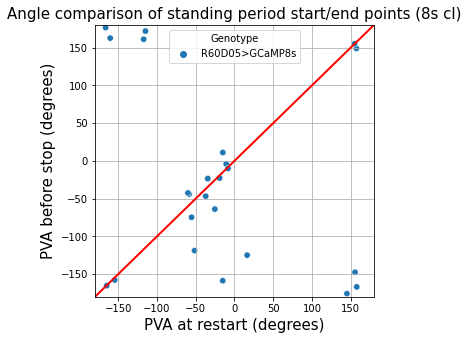

In [1090]:
plt.figure(figsize= (5,5))
sns.scatterplot(data = PVA_combined, x='PVA_at_restart', y='PVA_before_stop', hue = 'Genotype',s=40)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/end points (8s cl)', fontsize =15)
plt.xlabel('PVA at restart (degrees)',fontsize= 15)
plt.ylabel('PVA before stop (degrees)',fontsize= 15)
plt.grid()
plt.show()

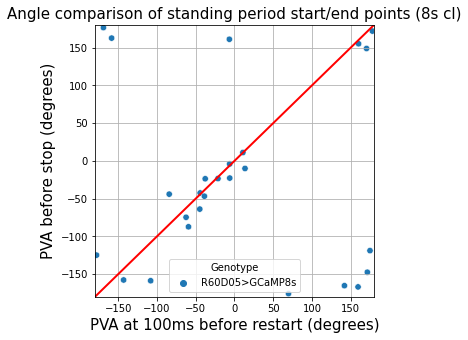

In [753]:
plt.figure(figsize= (5,5))
sns.scatterplot(data = PVA_combined, x='PVA_100ms_before_restart', y='PVA_before_stop',  hue = 'Genotype',s=40)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/end points (8s cl)', fontsize =15)
plt.xlabel('PVA at 100ms before restart (degrees)', fontsize= 15)
plt.ylabel('PVA before stop (degrees)',fontsize= 15)
plt.grid()
plt.show()

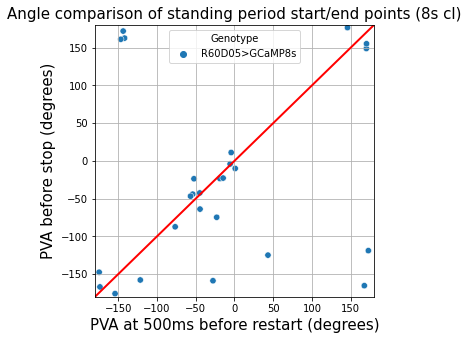

In [754]:
plt.figure(figsize= (5,5))
sns.scatterplot(data = PVA_combined, x='PVA_500ms_before_restart', y='PVA_before_stop',  hue = 'Genotype',s=40)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.title('Angle comparison of standing period start/end points (8s cl)', fontsize =15)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.xlabel('PVA at 500ms before restart (degrees)', fontsize= 15)
plt.ylabel('PVA before stop (degrees)',fontsize= 15)
plt.grid()
plt.show()

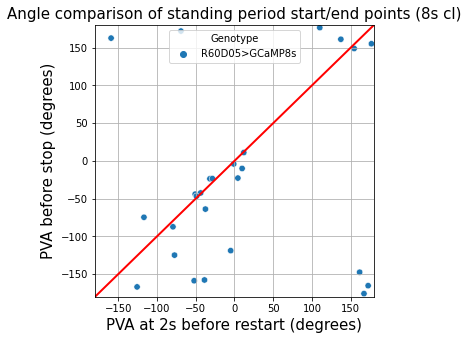

In [755]:
plt.figure(figsize= (5,5))
sns.scatterplot(data = PVA_combined, x='PVA_2s_before_restart', y='PVA_before_stop',  hue = 'Genotype',s=40)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.title('Angle comparison of standing period start/end points (8s cl)', fontsize =15)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.xlabel('PVA at 2s before restart (degrees)', fontsize= 15)
plt.ylabel('PVA before stop (degrees)',fontsize= 15)
plt.grid()
plt.show()

In [745]:
PVA_combined.corr(method='pearson')

PVA_before_stop  PVA_at_restart  \
PVA_before_stop                  1.000000        0.089587   
PVA_at_restart                   0.089587        1.000000   
PVA_100ms_before_restart         0.139970        0.493366   
PVA_500ms_before_restart         0.228226        0.256787   
PVA_2s_before_restart            0.263455        0.313426   

                          PVA_100ms_before_restart  PVA_500ms_before_restart  \
PVA_before_stop                           0.139970                  0.228226   
PVA_at_restart                            0.493366                  0.256787   
PVA_100ms_before_restart                  1.000000                  0.460537   
PVA_500ms_before_restart                  0.460537                  1.000000   
PVA_2s_before_restart                     0.672533                  0.543502   

                          PVA_2s_before_restart  
PVA_before_stop                        0.263455  
PVA_at_restart                         0.313426  
PVA_100ms_before_restart               0.672533  
PVA_500ms_before_restart               0.543502  
PVA_2s_before_restart                  1.000000

In [746]:
from astropy.stats import circcorrcoef

In [747]:
circcorrcoef(PVA_combined['PVA_2s_before_restart'],PVA_combined['PVA_before_stop'])

-0.09162446988981161